
# 수면 설문 데이터 자동화 EDA 노트북

이 노트북은 **변수 메타데이터(범주형/연속형/설명) 엑셀**을 활용해 다음을 자동으로 수행합니다.
1. 데이터/메타데이터 로드 및 타입 변환
2. 기술통계 요약 (범주형 vs 연속형)
3. 자동 시각화 (히스토그램, 카운트 플롯, 박스플롯)
4. 기본 집단 비교 (교대 vs 비교대, 성별)
5. 상관 히트맵 및 (선택) 요인분석(EFA), 카이제곱 검정

> **사용 전 준비**  
> - 설문 데이터 파일 경로 (예: `sleep_survey.xlsx`)  
> - 변수 메타데이터 파일 경로 (예: `variables_meta.xlsx`)  
> - 메타 파일에는 최소한 다음 컬럼이 있어야 합니다: `변수명`, `범주형`, `연속형`, `타입`, `변수설명`


In [1]:

# ==== 경로 설정 ====
DATA_FILE = "D:\_UserData_\Downloads\수면과제 관련 자료\Sleep Hi_KSHS_2nd_data_250811.xlsx"         # 설문 데이터(.xlsx)
META_FILE = "D:\_UserData_\Downloads\수면과제 관련 자료\Sleep Hi_Variable_250811.xlsx"       # 변수 메타데이터(.xlsx)
OUT_DIR = "eda_results"                 # 결과 이미지 저장 폴더

# ==== 라이브러리 ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import re

# 선택 라이브러리 (미설치 시 주석 처리 가능)
try:
    from factor_analyzer import FactorAnalyzer
    HAS_FACTOR = True
except Exception:
    HAS_FACTOR = False
    print("[알림] factor_analyzer가 설치되어 있지 않습니다. (pip install factor-analyzer)")

# 한글 폰트 설정 (환경에 따라 주석 필요)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 환경에 맞게 변경하세요
plt.rcParams['axes.unicode_minus'] = False

os.makedirs(OUT_DIR, exist_ok=True)
print("환경 준비 완료.")


환경 준비 완료.


In [2]:

# ==== 데이터/메타데이터 로드 ====
df = pd.read_excel(DATA_FILE)
meta = pd.read_excel(META_FILE)

print("데이터 크기:", df.shape)
print("컬럼 예시:", df.columns[:10].tolist())

# 메타 필수 컬럼 체크
required_cols = {"변수명", "범주형", "연속형"}
missing_meta_cols = required_cols - set(meta.columns)
if missing_meta_cols:
    raise ValueError(f"메타데이터에 필요한 컬럼이 없습니다: {missing_meta_cols}")

# 범주/연속 변수 리스트
categorical_vars = meta.loc[meta["범주형"] == 1, "변수명"].dropna().astype(str).tolist()
continuous_vars = meta.loc[meta["연속형"] == 1, "변수명"].dropna().astype(str).tolist()

# 실제 df에 존재하는 컬럼만 사용
categorical_vars = [c for c in categorical_vars if c in df.columns]
continuous_vars = [c for c in continuous_vars if c in df.columns]

print("범주형 변수 개수:", len(categorical_vars))
print("연속형 변수 개수:", len(continuous_vars))


데이터 크기: (2501, 97)
컬럼 예시: ['ID', 'SW', 'sex', 'age', 'age_group', 'Q59_1_w', 'Q59_1_f', 'D3_1_ht', 'D3_2_wt', 'BMI']
범주형 변수 개수: 21
연속형 변수 개수: 75


In [3]:
# 특정 열의 값 하나 출력
print("예시 값:", df["MCTQ_GUa"].values[:5])
print("예시 값:", df["MCTQ_MSF"].values[:5])
print("예시 값:", df["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df["MCTQ_MBF"].values[:5])
print("예시 값:", df["MCTQ_SOf_c"].values[:5])
print("예시 값:", df["MCTQ_SOa_c"].values[:5])
print("예시 값:", df["MCTQ_SOw_c"].values[:5])

예시 값: [datetime.time(10, 30) datetime.time(9, 4, 17, 143000)
 datetime.time(8, 22, 8, 571000) datetime.time(9, 55, 51, 429000)
 datetime.time(8, 18, 34, 286000)]
예시 값: [datetime.time(5, 40) datetime.time(5, 5) datetime.time(4, 32, 30)
 datetime.time(8, 20) datetime.time(4, 20)]
예시 값: [datetime.time(2, 10) datetime.time(0, 35) datetime.time(0, 2, 30)
 datetime.time(2, 50) datetime.time(0, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 5, 45) datetime.datetime(1900, 1, 1, 4, 50)
 datetime.datetime(1900, 1, 1, 4, 32, 30)
 datetime.datetime(1900, 1, 1, 8, 1, 30)
 datetime.datetime(1900, 1, 1, 4, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 0, 20) datetime.datetime(1900, 1, 1, 0, 40)
 datetime.datetime(1900, 1, 1, 0, 5) datetime.datetime(1900, 1, 1, 3, 40)
 datetime.datetime(1900, 1, 1, 0, 10)]
예시 값: [datetime.datetime(1900, 1, 1, 1, 28, 34, 286000)
 datetime.datetime(1900, 1, 1, 0, 4, 17, 143000)
 datetime.datetime(1900, 1, 1, 0, 5)
 datetime.datetime(1900, 1, 1, 3, 25, 42, 857000)
 datetime.datet

In [4]:
# ------------------------
# Robust converters
# ------------------------

def convert_hhmm_columns_inplace(df: pd.DataFrame, cols_hhmm, *, accept_float_hours=True):
    """
    cols_hhmm 열들을 '분(min)' 숫자로 덮어씀.
    - datetime64[ns]: 벡터화(.dt.hour*60 + .dt.minute)
    - object: python datetime.time / datetime.datetime / 문자열 혼합 대응
    - float/int인데 meta는 hh:mm: 시간 단위로 보고 *60 (옵션)
    """
    for col in cols_hhmm:
        if col not in df.columns:
            continue
        s = df[col]

        # 1) datetime64 계열 → 벡터화
        if pd.api.types.is_datetime64_any_dtype(s):
            out = (s.dt.hour * 60 + s.dt.minute).astype("float")

        # 2) object 혼합형
        elif pd.api.types.is_object_dtype(s):
            # 우선 python datetime 직접 꺼내기
            is_py_time = s.dropna().map(lambda v: isinstance(v, dt.time)).any()
            is_py_dt   = s.dropna().map(lambda v: isinstance(v, dt.datetime)).any()

            if is_py_time or is_py_dt:
                # element-wise 우선 변환
                out = s.map(hhmm_to_minutes_robust)
                # 남은 NaN은 일괄 파싱으로 보강
                mask = out.isna()
                if mask.any():
                    parsed = pd.to_datetime(s[mask], errors="coerce")
                    out.loc[mask] = (parsed.dt.hour * 60 + parsed.dt.minute).astype("float")
            else:
                # 순수 문자열/혼합 → 일괄 파싱
                parsed = pd.to_datetime(s, errors="coerce")
                out = (parsed.dt.hour * 60 + parsed.dt.minute).astype("float")

        # 3) 숫자형인데 meta가 hh:mm로 찍힌 경우(시간 단위로 가정)
        elif pd.api.types.is_integer_dtype(s) or pd.api.types.is_float_dtype(s):
            out = s.astype("float") * 60.0 if accept_float_hours else s.astype("float")

        else:
            # 마지막 보루
            parsed = pd.to_datetime(s.astype(str), errors="coerce")
            out = (parsed.dt.hour * 60 + parsed.dt.minute).astype("float")

        df[col] = out



# hh:mm, hh:mm:ss(.us) 문자열 정규화 (전각 콜론, 공백 등)
def _normalize_time_str(x: str) -> str:
    x = x.strip()
    x = x.replace("：", ":")         # 전각 콜론 -> 일반 콜론
    x = re.sub(r"\s+", "", x)        # 모든 공백 제거
    return x

# HH:MM(:SS[.us]) 전체 대응
_pat_any_time = re.compile(r"^(\d{1,2}):(\d{1,2})(?::(\d{1,2})(?:\.(\d+)?)?)?$")

def hhmm_to_minutes_robust(x):
    """다양한 시간표현 → 분(min). 초/마이크로초는 무시."""
    if pd.isna(x):
        return np.nan

    # python datetime.time
    if isinstance(x, dt.time):
        return x.hour * 60 + x.minute

    # ✅ python datetime.datetime (명시 추가)
    if isinstance(x, dt.datetime):
        return x.hour * 60 + x.minute

    # pandas Timestamp
    if isinstance(x, pd.Timestamp):
        return x.hour * 60 + x.minute

    # numpy datetime64
    if isinstance(x, np.datetime64):
        t = pd.to_datetime(x, errors="coerce")
        if pd.isna(t): 
            return np.nan
        return t.hour * 60 + t.minute

    # 문자열
    if isinstance(x, str):
        x = x.strip()
        if not x:
            return np.nan
        t = pd.to_datetime(x, errors="coerce")
        if pd.isna(t):
            return np.nan
        return t.hour * 60 + t.minute

    return np.nan


_num_pat = re.compile(r"[-+]?\d+(\.\d+)?")

def minute_to_numeric_robust(x):
    """분 단위 숫자 변환. '10분', '15 min', '>=30', '1,200' 등도 처리."""
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return float(x)
    s = str(x).strip()
    if s == "":
        return np.nan
    # 자주 보이는 단위/기호 제거
    s = s.replace(",", "")
    for token in ["분", "min", "mins", "minute", "minutes"]:
        s = s.replace(token, "")
    s = s.replace("≥", ">=").replace("≤", "<=")

    # 숫자만 추출
    m = _num_pat.search(s)
    return float(m.group()) if m else np.nan

# ------------------------
# Audit 도우미 (선택)
# ------------------------
def _audit_convert(df, cols, conv_fn, sample_n=10):
    """변환 전 notna → 변환 후 na가 된 문제값 상위 예시를 dict로 리턴."""
    report = {}
    for col in cols:
        if col not in df.columns:
            continue
        s = df[col]
        before_mask = s.notna()
        after = s.apply(conv_fn)
        bad_idx = before_mask & after.isna()
        if bad_idx.any():
            report[col] = s[bad_idx].astype(str).value_counts().head(sample_n)
    return report

# ------------------------
# 메인: cast_with_meta (업데이트)
# ------------------------
def cast_with_meta(df, meta, *, run_audit=True, hhmm_to_int=False):
    meta = meta.copy()
    meta["타입_norm"] = meta["타입"].astype(str).str.lower().str.strip()

    categorical_vars = meta.loc[meta["범주형"] == 1, "변수명"].dropna().astype(str).tolist()
    continuous_vars  = meta.loc[meta["연속형"] == 1, "변수명"].dropna().astype(str).tolist()
    cols_hhmm        = meta.loc[meta["타입_norm"] == "hh:mm",   "변수명"].dropna().astype(str).tolist()
    cols_minute      = meta.loc[meta["타입_norm"] == "minute", "변수명"].dropna().astype(str).tolist()

    categorical_vars = [c for c in categorical_vars if c in df.columns]
    continuous_vars  = [c for c in continuous_vars  if c in df.columns]
    cols_hhmm        = [c for c in cols_hhmm        if c in df.columns]
    cols_minute      = [c for c in cols_minute      if c in df.columns]

    cat_exclude = set(cols_hhmm + cols_minute)
    categorical_vars = [c for c in categorical_vars if c not in cat_exclude]
    for c in cols_hhmm + cols_minute:
        if c not in continuous_vars:
            continuous_vars.append(c)

    # 1) hh:mm → 분(min)
    convert_hhmm_columns_inplace(df, cols_hhmm, accept_float_hours=True)
    if hhmm_to_int:
        for c in cols_hhmm:
            df[c] = df[c].astype("Int64")

    # 2) minute → 숫자
    for col in cols_minute:
        df[col] = df[col].apply(minute_to_numeric_robust).astype("float")

    # 3) 범주형
    for col in categorical_vars:
        try:
            df[col] = df[col].astype("category")
        except Exception:
            df[col] = df[col].astype(str).astype("category")

    # 4) 연속형(일반)
    for col in continuous_vars:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # ✅ 5) 마지막 안전망: 여전히 datetime 성분이 남은 열은 전수 변환
    for col in df.columns:
        s = df[col]
        if pd.api.types.is_datetime64_any_dtype(s):
            df[col] = (s.dt.hour * 60 + s.dt.minute).astype("float")
        elif pd.api.types.is_object_dtype(s):
            if s.dropna().map(lambda v: isinstance(v, (dt.time, dt.datetime, pd.Timestamp, np.datetime64))).any():
                df[col] = s.map(hhmm_to_minutes_robust).astype("float")

    # (선택) audit
    audit = None
    if run_audit:
        def _audit_convert(df, cols, conv_fn, sample_n=10):
            report = {}
            for col in cols:
                if col not in df.columns: 
                    continue
                s = df[col]
                before_mask = s.notna()
                after = s.map(conv_fn)
                bad_idx = before_mask & after.isna()
                if bad_idx.any():
                    report[col] = s[bad_idx].astype(str).value_counts().head(sample_n)
            return report

        audit = {
            "hhmm":   _audit_convert(df, cols_hhmm, hhmm_to_minutes_robust),
            "minute": _audit_convert(df, cols_minute, minute_to_numeric_robust),
        }

    return {
        "categorical": categorical_vars,
        "continuous": continuous_vars,
        "hhmm_converted": cols_hhmm,
        "minute_converted": cols_minute,
        "audit": audit
    }


In [5]:
info = cast_with_meta(df, meta, run_audit=True, hhmm_to_int=False)

print("범주형:", info["categorical"][:10])
print("연속형:", info["continuous"][:10])
print("hh:mm 변환:", info["hhmm_converted"][:10])
print("minute 변환:", info["minute_converted"][:10])

# 변환 후 NaN으로 떨어진 문제값 상위 예시 확인
bad_hhmm = info["audit"]["hhmm"]
for col, vc in bad_hhmm.items():
    print(f"\n[hh:mm 변환 NaN 원인 상위] {col}\n{vc}")

bad_min = info["audit"]["minute"]
for col, vc in bad_min.items():
    print(f"\n[minute 변환 NaN 원인 상위] {col}\n{vc}")


# 변환 전/후 비교: 특정 열에서 NaN이 증가한 행들만 확인
def inspect_diffs(df, col):
    before = df[col].copy()
    # 임시로 원본 백업 후 변환 테스트
    tmp = before.copy()
    df[col] = before  # (이미 변환이 됐다면 이 줄은 생략)
    convert_hhmm_columns_inplace(df, [col], accept_float_hours=True)
    after = df[col]
    bad = before.notna() & after.isna()
    print(col, "변환 전 notna:", before.notna().sum(), "→ 변환 후 notna:", after.notna().sum())
    if bad.any():
        print("[NaN 유발 상위 값]")
        print(before[bad].astype(str).value_counts().head(10))
    # 원상복구 (원하면)
    df[col] = tmp

# 예)
inspect_diffs(df, "MCTQ_BTw_c")

범주형: ['SW', 'sex', 'age_group', 'D4_edu', 'D5_income', 'Q56_alc', 'Q57_smok', 'Q58_exercise', 'Q88_snor', 'Q89_apnea']
연속형: ['age', 'Q59_1_w', 'Q59_1_f', 'D3_1_ht', 'D3_2_wt', 'BMI', 'MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_GUw']
hh:mm 변환: ['MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_GUw', 'MCTQ_GUf', 'MCTQ_GUa', 'MCTQ_MBW', 'MCTQ_MBF', 'MCTQ_Sprepw_c', 'MCTQ_Sprepf_c']
minute 변환: ['MCTQ_TBTw_c', 'MCTQ_TBTf_c', 'MCTQ_TBTa_c', 'MCTQ_TFSw', 'MCTQ_TFSf', 'MCTQ_TFSa', 'MCTQ_TFPw', 'MCTQ_TFPf', 'MCTQ_TFPa', 'Q64_SIw']

[hh:mm 변환 NaN 원인 상위] MCTQ_BTw_c
MCTQ_BTw_c
1380    563
0       366
1320    304
1410    234
1350    213
1260     96
60       93
30       73
1290     65
1370     48
Name: count, dtype: int64

[hh:mm 변환 NaN 원인 상위] MCTQ_BTf_c
MCTQ_BTf_c
1380    515
0       490
1320    244
1410    224
60      176
1350    150
30      135
120      73
1260     72
90       45
Name: count, dtype: int64

[hh:mm 변환 NaN 원인 상위] MCTQ_BTa_c
MCTQ_BTa_c
1380.0    304
0.0       238
1320.0    171
1410

C:\Users\Lee\AppData\Local\Temp\ipykernel_37064\1106505860.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.values, y=missing_counts.index, palette="Blues_r")


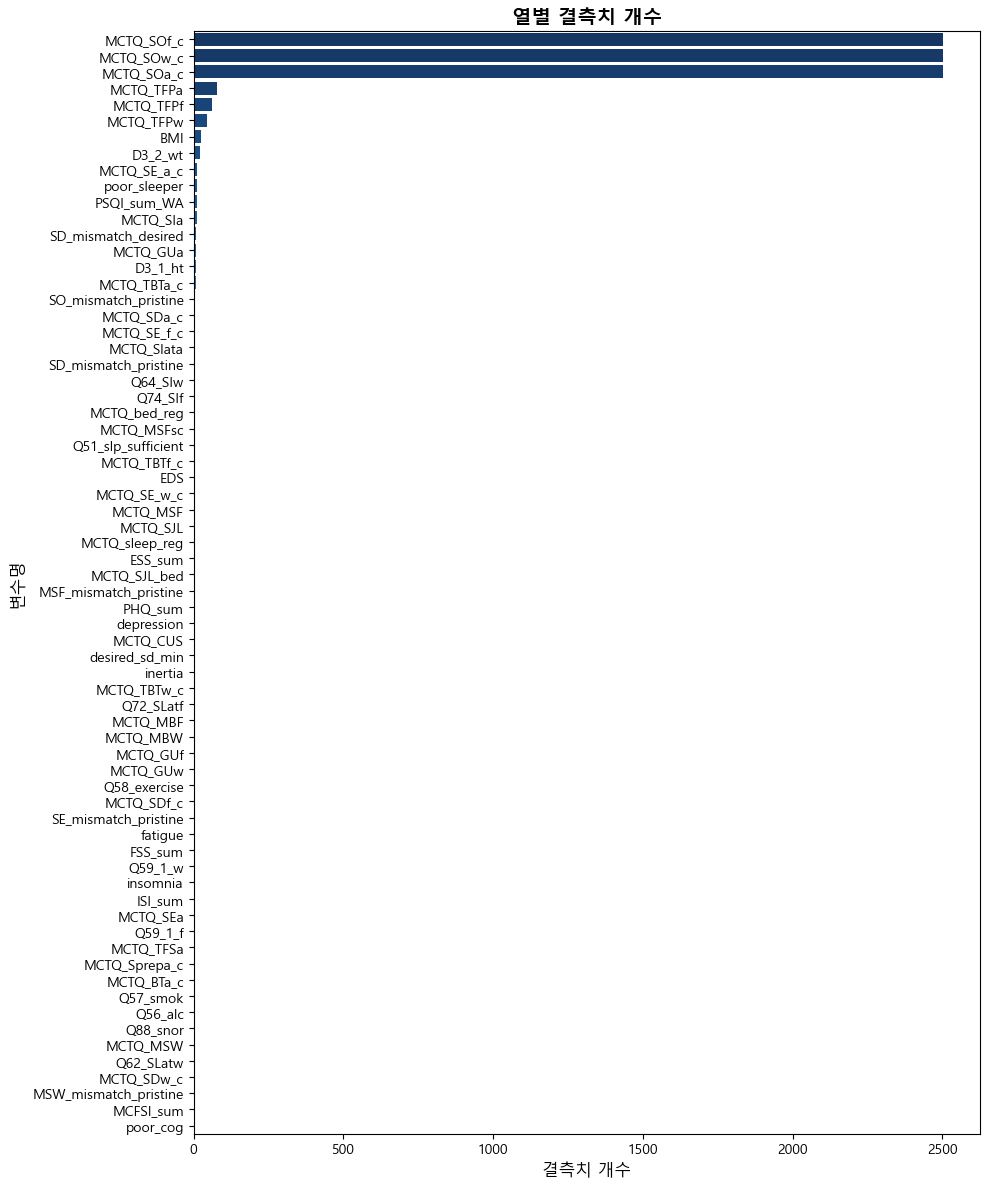

In [6]:
# 1. 열별 결측치 개수 계산
missing_counts = df.isnull().sum()

# 2. 결측치 있는 열만 추림 & 내림차순 정렬
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# 3. Barplot 시각화
plt.figure(figsize=(10, 12))
sns.barplot(x=missing_counts.values, y=missing_counts.index, palette="Blues_r")
plt.xlabel("결측치 개수", fontsize=12)
plt.ylabel("변수명", fontsize=12)
plt.title("열별 결측치 개수", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

C:\Users\Lee\AppData\Local\Temp\ipykernel_37064\63180369.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_counts.values, y=filtered_counts.index, palette="Blues_r")


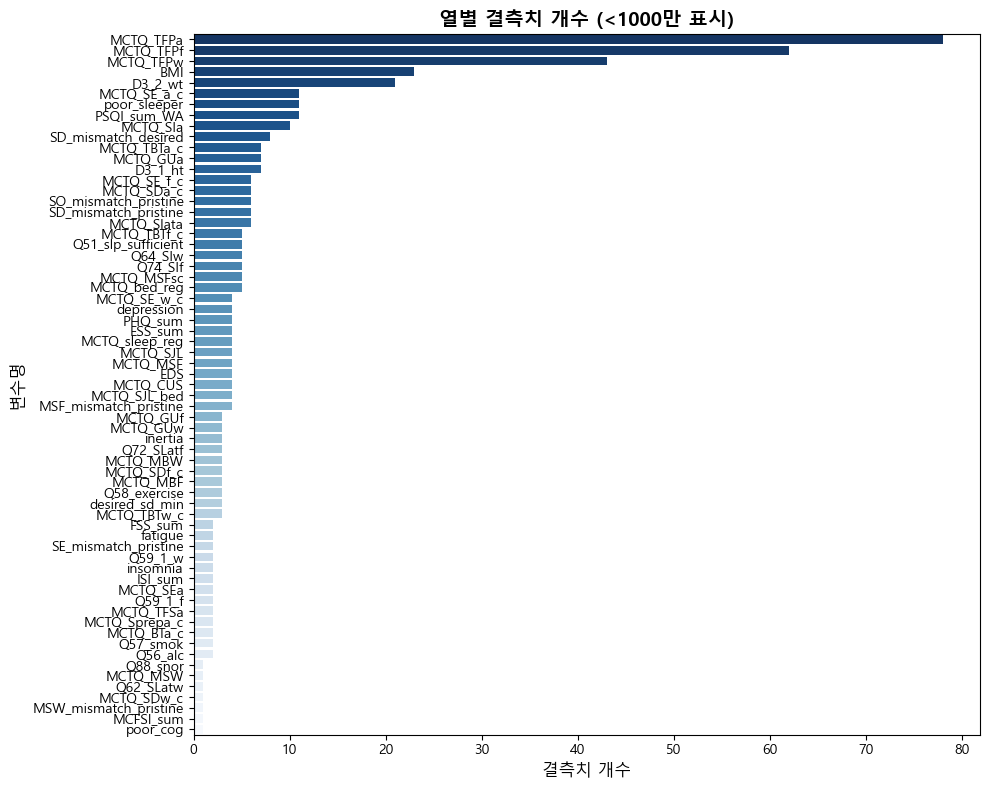

In [10]:
# 1. 열별 결측치 개수
missing_counts = df.isnull().sum()

# 2. 결측치 있는 열만 추림
missing_counts = missing_counts[missing_counts > 0]

# 3. 1000 이상인 변수 제외
filtered_counts = missing_counts[missing_counts < 1000].sort_values(ascending=False)

# 4. Barplot 그리기
plt.figure(figsize=(10, 8))
sns.barplot(x=filtered_counts.values, y=filtered_counts.index, palette="Blues_r")
plt.xlabel("결측치 개수", fontsize=12)
plt.ylabel("변수명", fontsize=12)
plt.title("열별 결측치 개수 (<1000만 표시)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# 통계 시작

In [9]:

# ==== 기술통계 요약 ====
# 출력할 때 행/열 잘림 없이 전부 보고 싶을 때
pd.set_option("display.max_rows", None)      # 행 모두 출력
pd.set_option("display.max_columns", None)   # 열 모두 출력
pd.set_option("display.max_colwidth", None)  # 문자열 전체 출력
pd.set_option("display.expand_frame_repr", False)  # 줄바꿈 없이 가로로 다 보여줌




# 범주형 요약
print("=== 범주형 변수 요약 ===")
for col in categorical_vars:
    print(f"\n▶ {col}")
    try:
        print(df[col].value_counts(dropna=False))
    except Exception as e:
        print(f"[경고] {col} 요약 실패:", e)

# 연속형 요약
print("\n=== 연속형 변수 요약 ===")
if continuous_vars:
    display(df[continuous_vars].describe().T)
else:
    print("연속형 변수가 없습니다.")


=== 범주형 변수 요약 ===

▶ SW
SW
2    2409
1      92
Name: count, dtype: int64

▶ sex
sex
2    1259
1    1242
Name: count, dtype: int64

▶ age_group
age_group
3    498
4    498
1    434
2    425
5    345
6    240
7     61
Name: count, dtype: int64

▶ D4_edu
D4_edu
3    1063
4    1018
2     230
1     163
5      27
Name: count, dtype: int64

▶ D5_income
D5_income
9     488
10    466
7     357
8     315
6     199
11    183
5     142
12     98
3      92
4      83
2      63
1      15
Name: count, dtype: int64

▶ Q56_alc
Q56_alc
8.0    534
5.0    472
4.0    457
6.0    439
3.0    373
7.0    101
2.0     71
1.0     52
NaN      2
Name: count, dtype: int64

▶ Q57_smok
Q57_smok
3.0    1553
1.0     607
2.0     339
NaN       2
Name: count, dtype: int64

▶ Q58_exercise
Q58_exercise
5.0    1406
4.0     571
3.0     313
1.0     113
2.0      95
NaN       3
Name: count, dtype: int64

▶ Q88_snor
Q88_snor
2.0    1278
1.0    1001
3.0     221
NaN       1
Name: count, dtype: int64

▶ Q89_apnea
Q89_apnea
2    2001
3 

,count,mean,std,min,25%,50%,75%,max
age,2501.0,47.915634,16.362851,19.000000,34.000000,48.000000,60.000000,92.000000
Q59_1_w,2499.0,5.324130,0.619749,1.000000,5.000000,5.000000,6.000000,6.000000
Q59_1_f,2499.0,1.675870,0.619749,1.000000,1.000000,2.000000,2.000000,6.000000
D3_1_ht,2494.0,165.996792,8.221268,143.000000,160.000000,165.000000,173.000000,191.000000
D3_2_wt,2480.0,63.867137,10.690057,30.000000,55.000000,63.000000,70.000000,116.000000
BMI,2478.0,23.075347,2.783719,9.795918,21.225339,22.981902,24.801587,38.062284
MCTQ_BTw_c,2501.0,1004.294282,586.955630,0.000000,120.000000,1340.000000,1380.000000,1435.000000
MCTQ_BTf_c,2501.0,822.272291,652.168660,0.000000,30.000000,1320.000000,1380.000000,1435.000000
MCTQ_BTa_c,2499.0,1010.340536,587.687095,0.000000,120.000000,1350.000000,1384.000000,1438.000000
MCTQ_GUw,2498.0,408.453163,76.253290,65.000000,370.000000,405.000000,435.000000,1290.000000


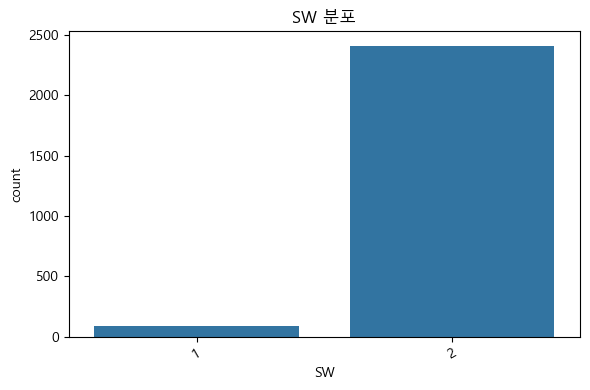

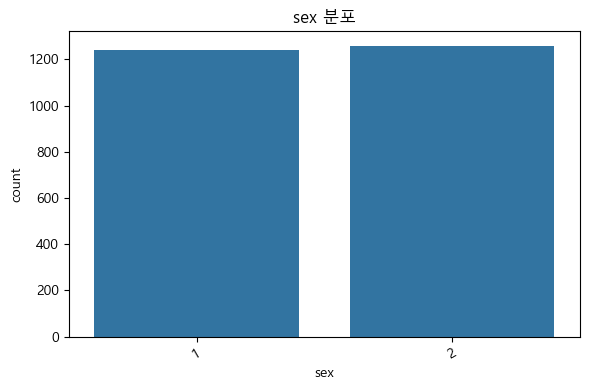

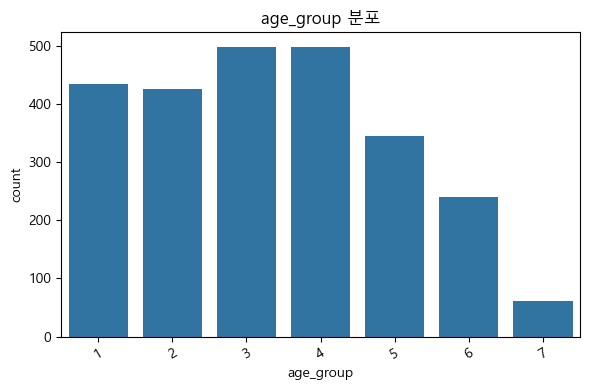

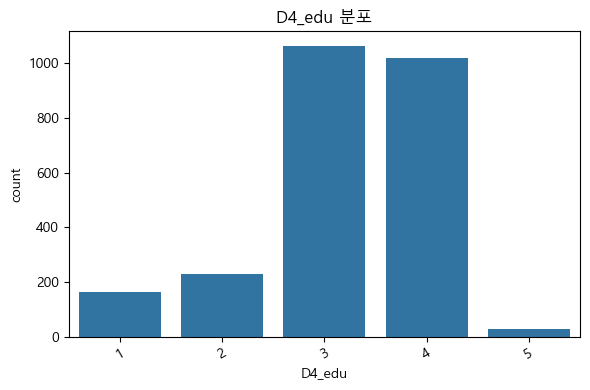

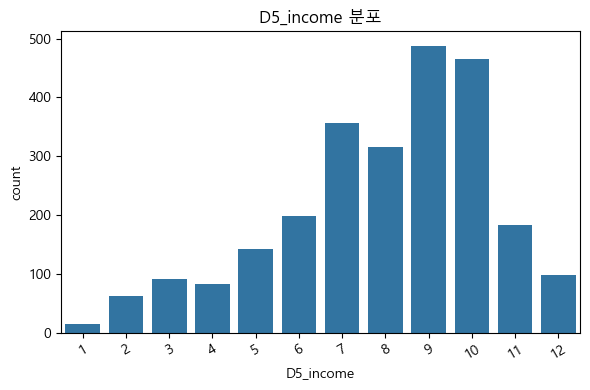

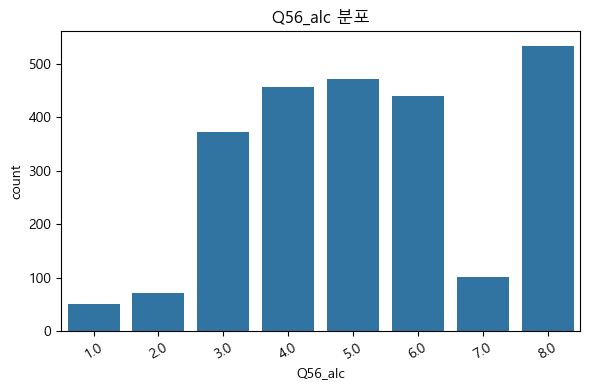

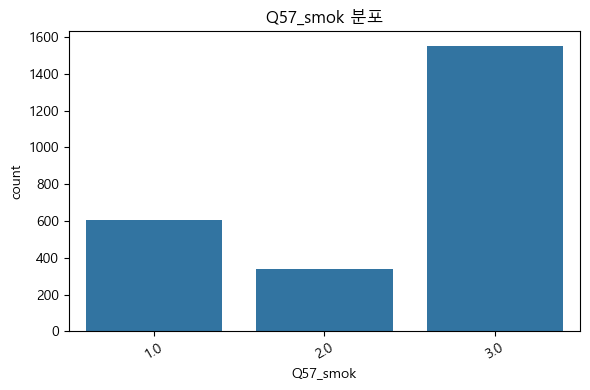

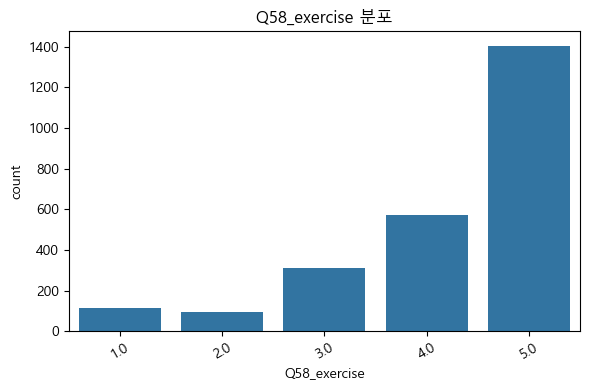

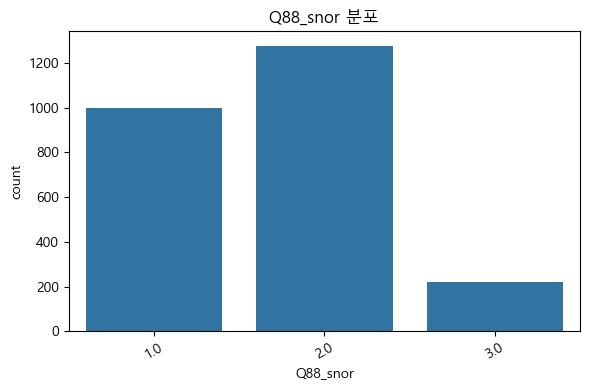

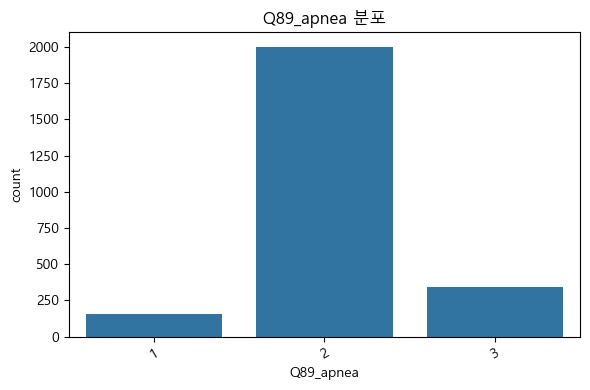

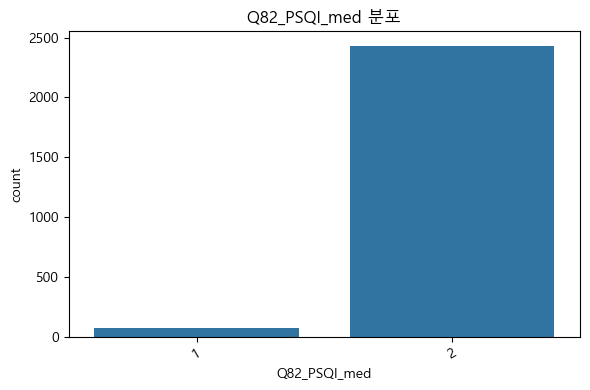

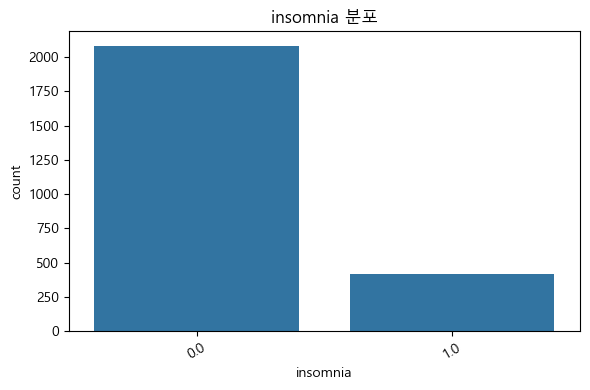

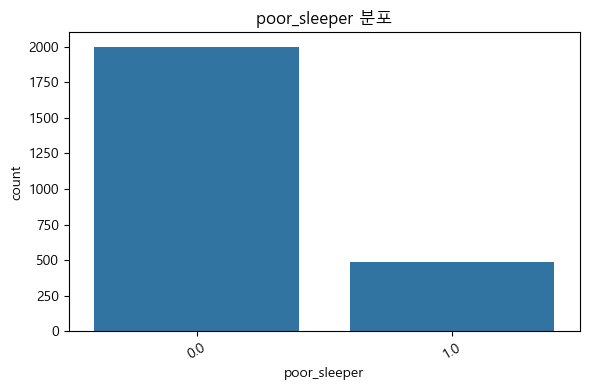

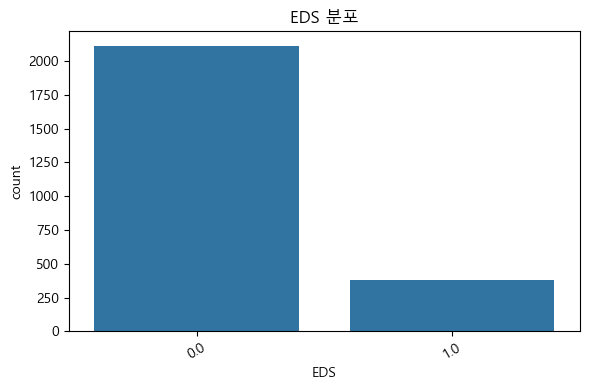

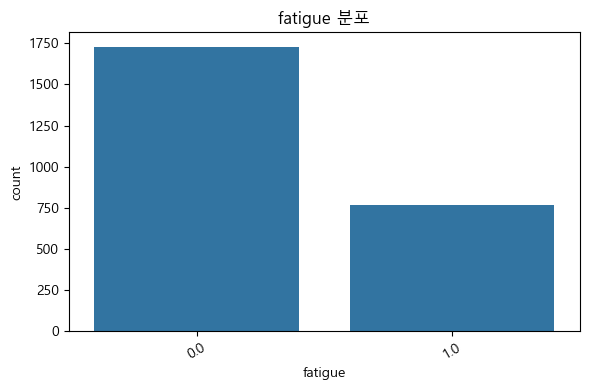

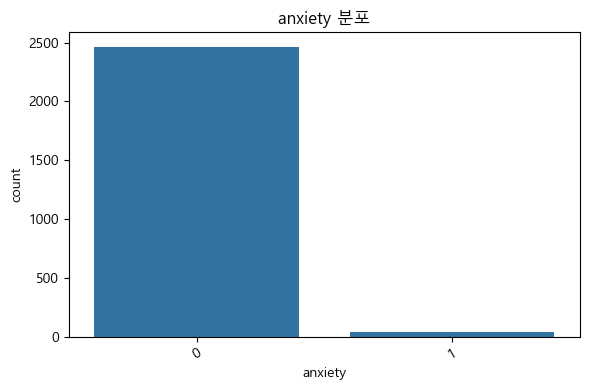

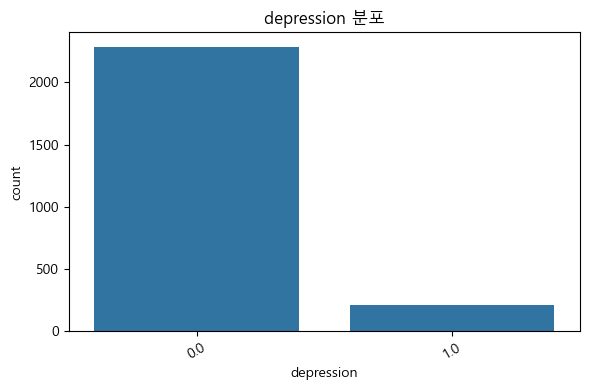

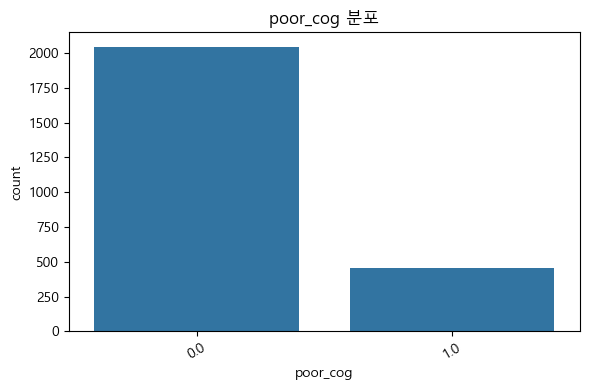

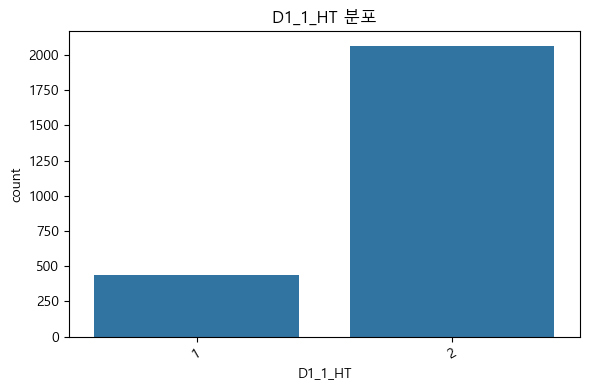

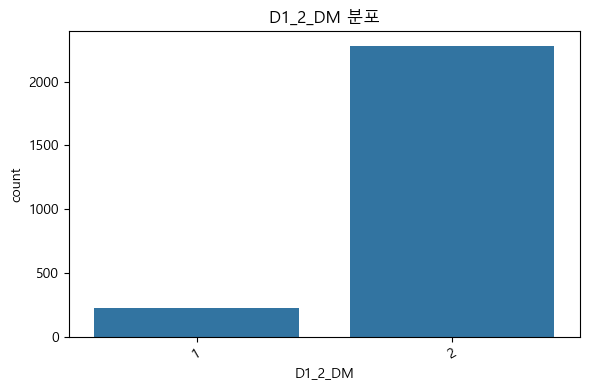

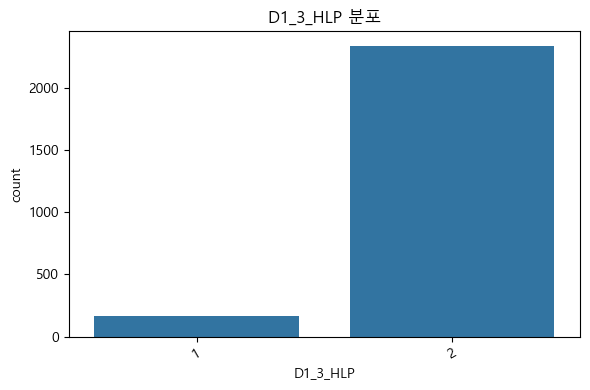

In [11]:

# ==== 범주형 시각화: countplot ====
for col in categorical_vars:
    try:
        plt.figure(figsize=(6,4))
        sns.countplot(data=df, x=col)
        plt.title(f"{col} 분포")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.savefig(f"{OUT_DIR}/{col}_countplot.png", dpi=150)
        plt.show()
    except Exception as e:
        print(f"[경고] {col} 시각화 실패:", e)


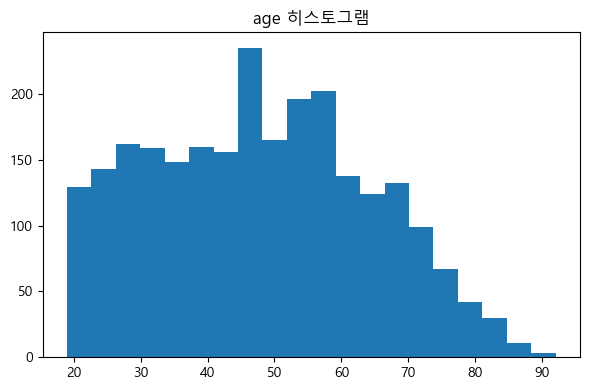

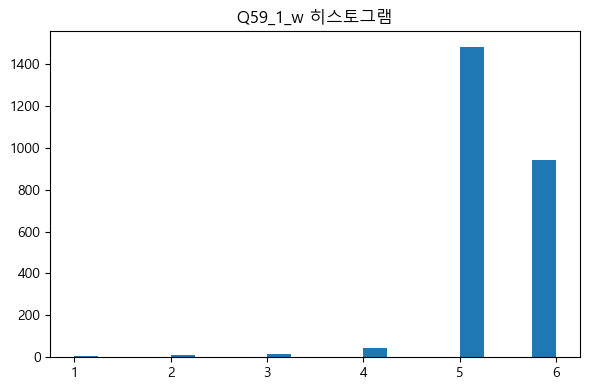

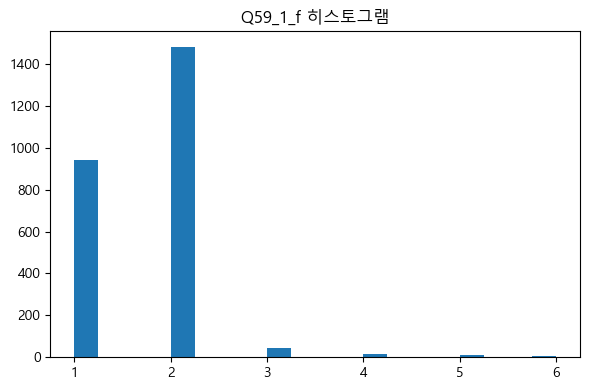

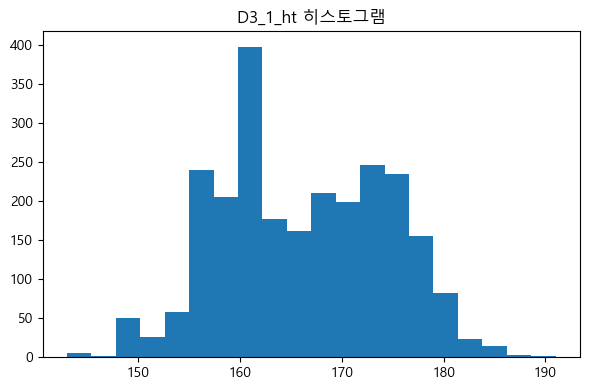

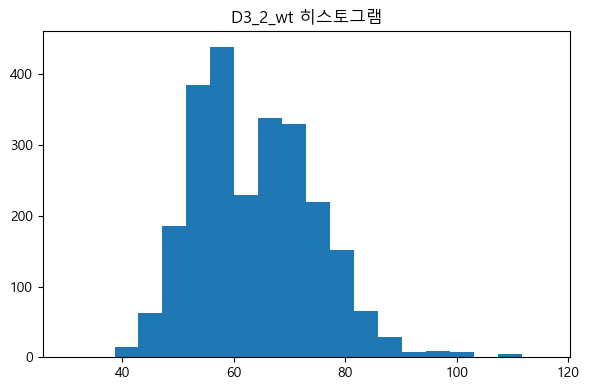

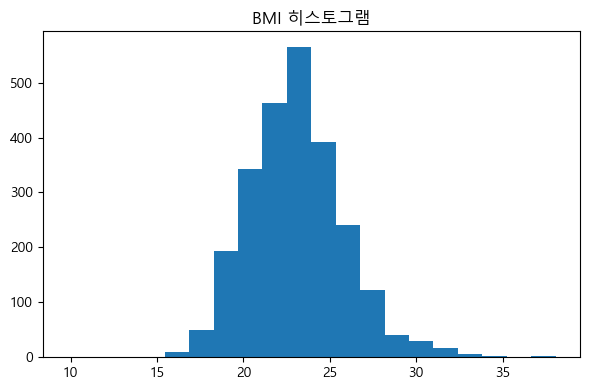

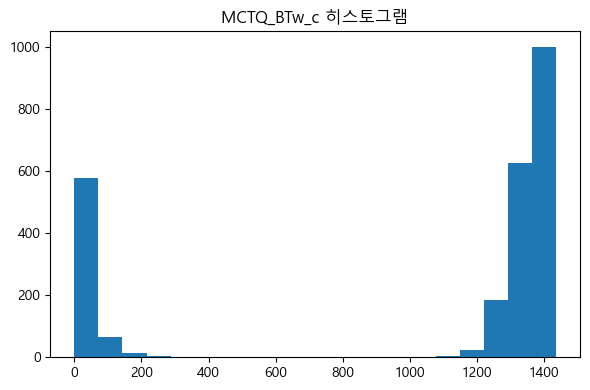

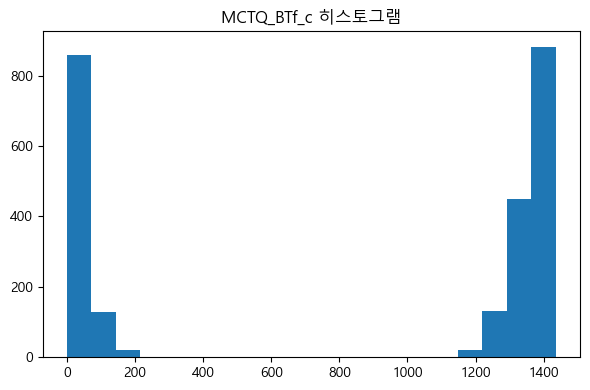

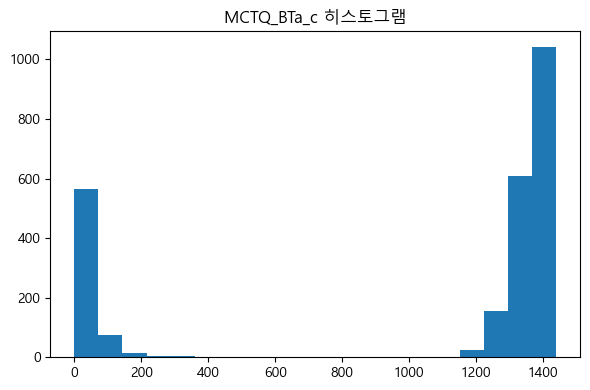

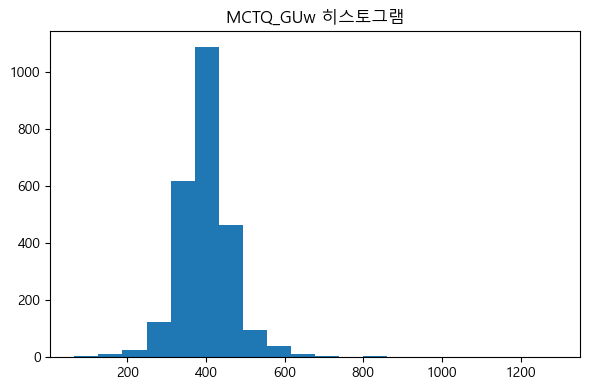

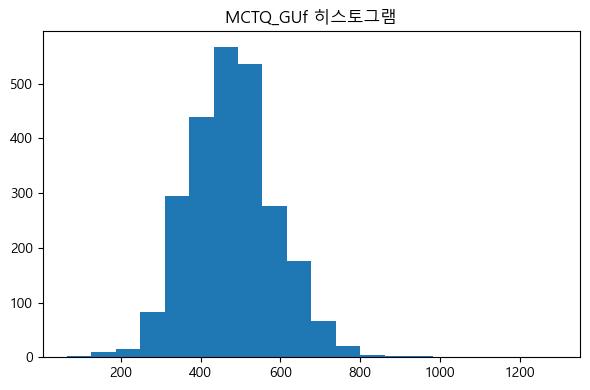

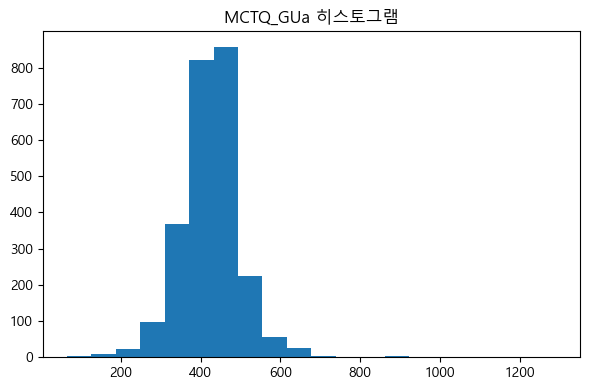

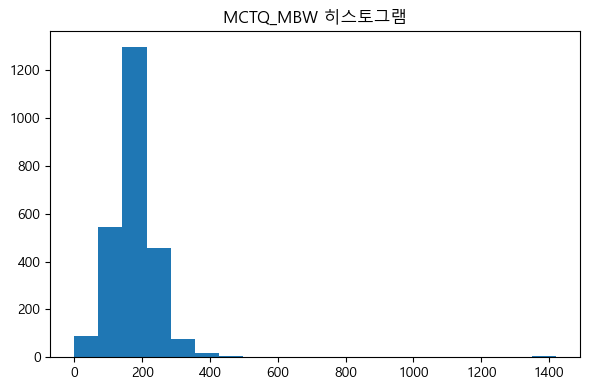

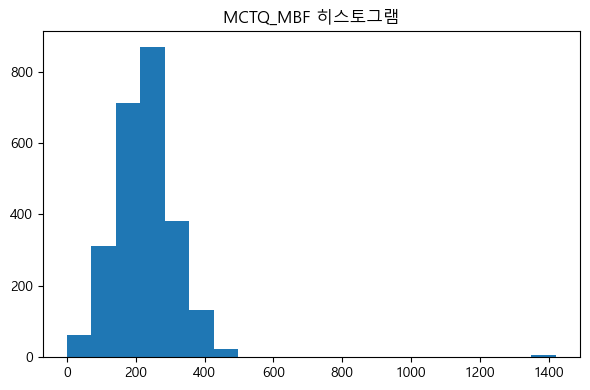

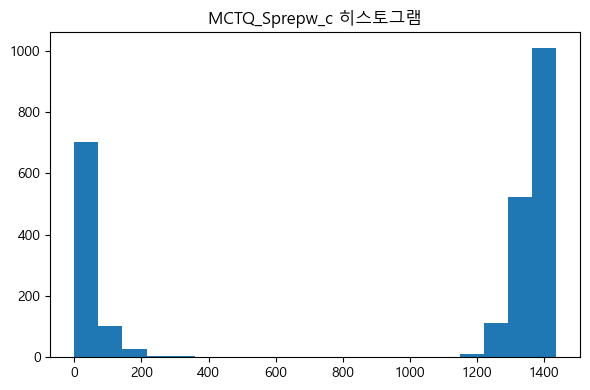

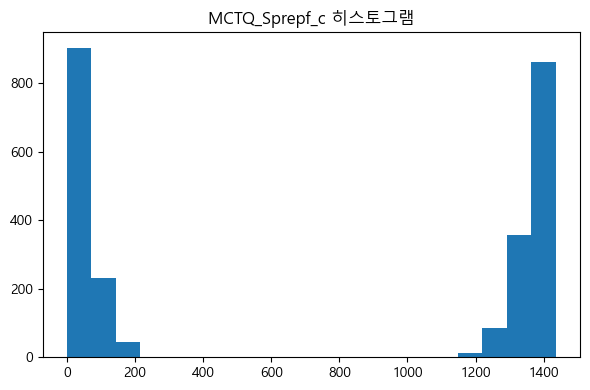

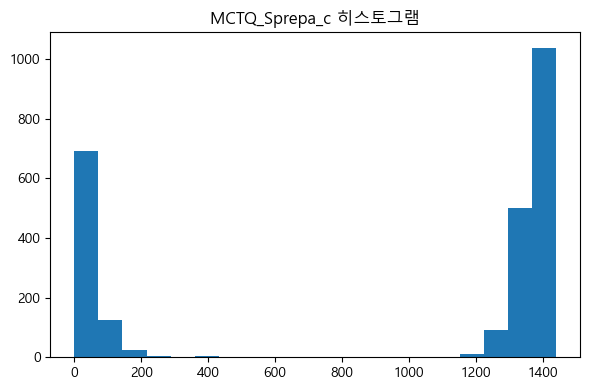

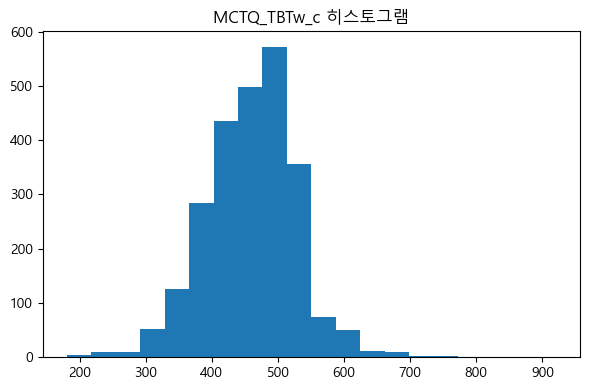

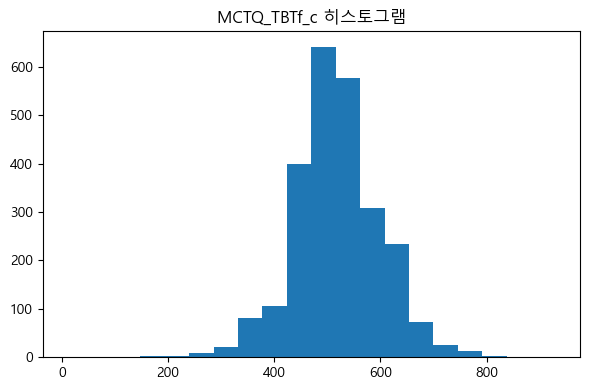

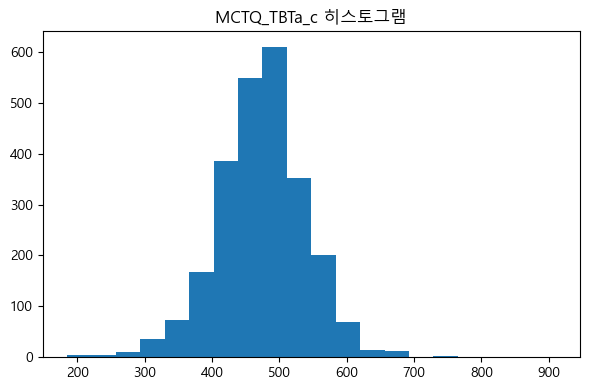

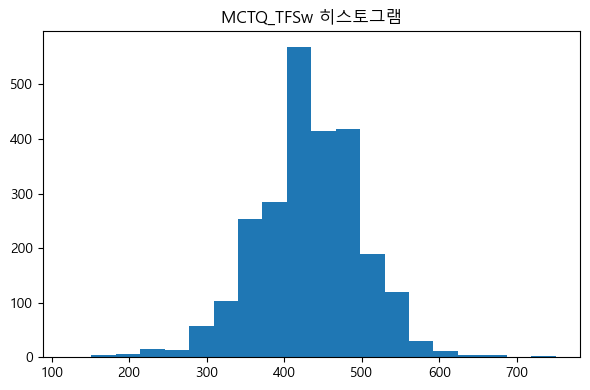

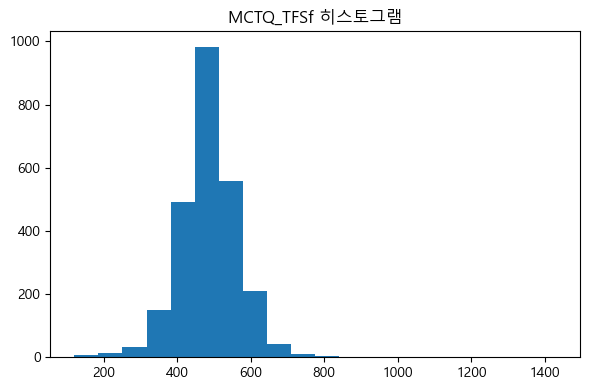

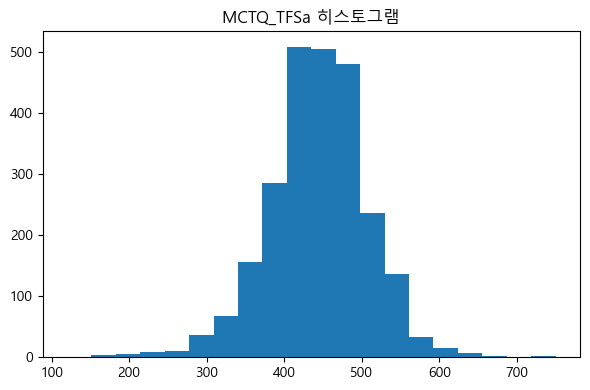

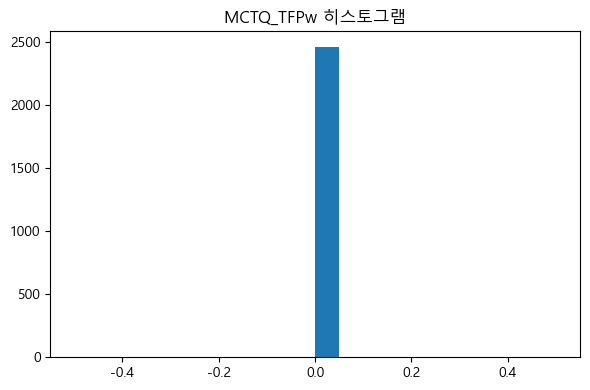

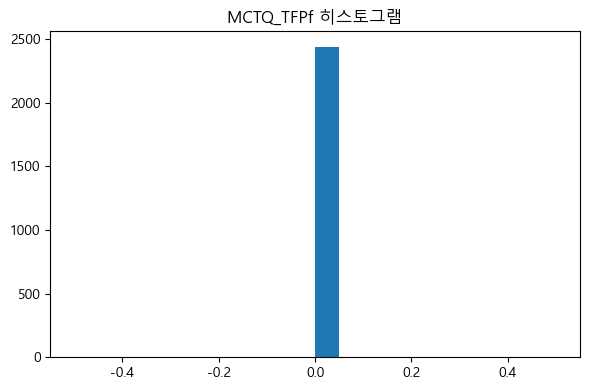

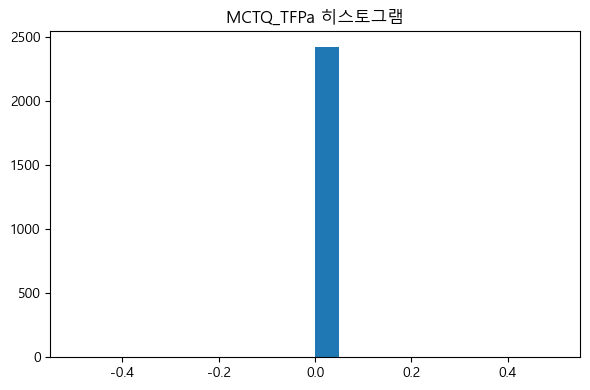

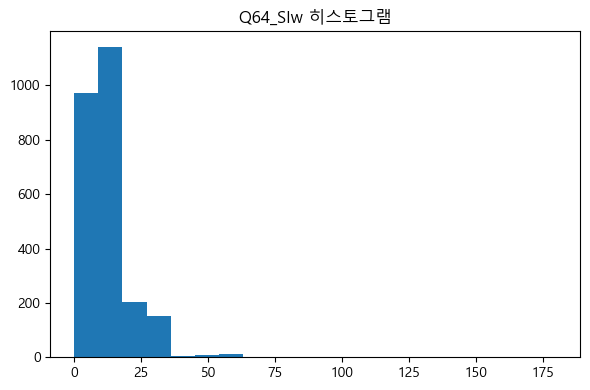

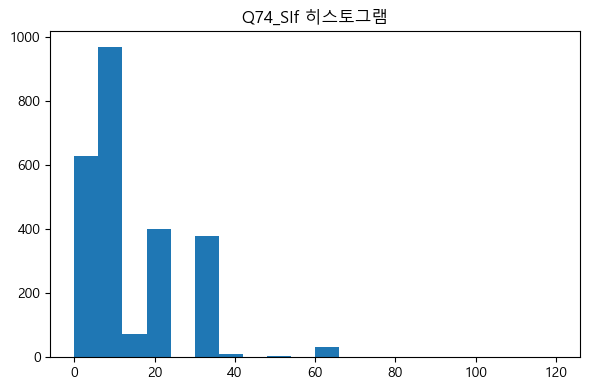

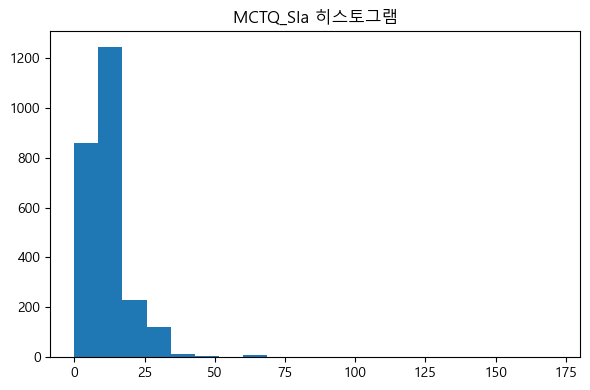

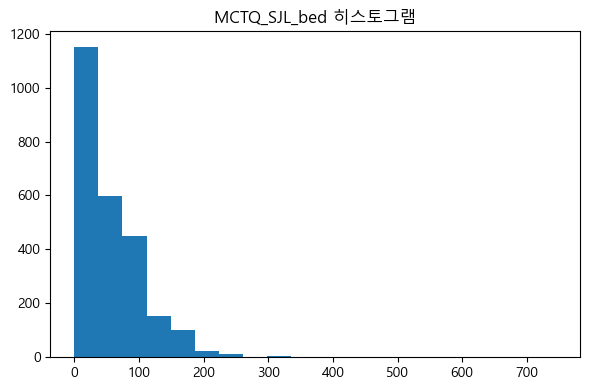

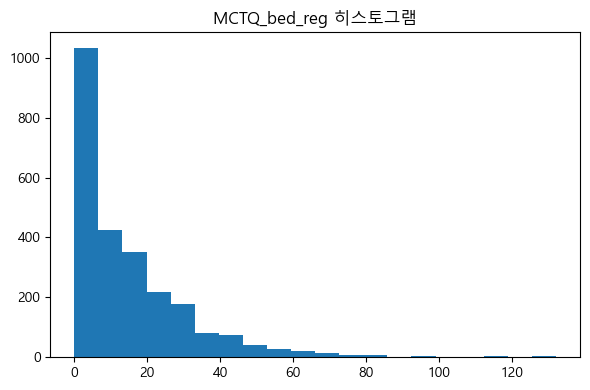

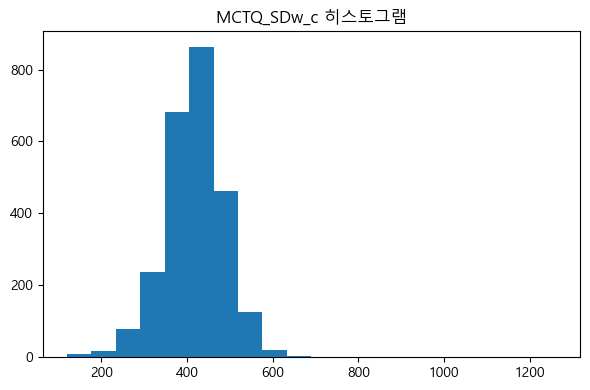

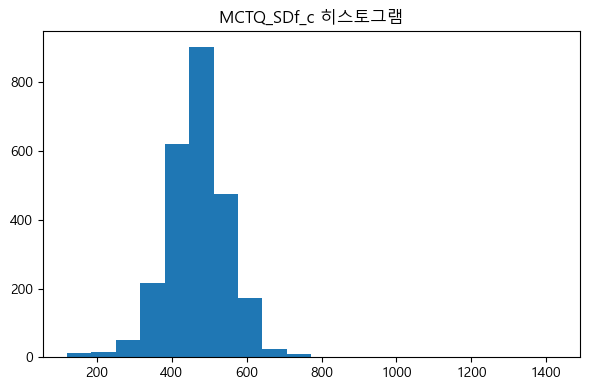

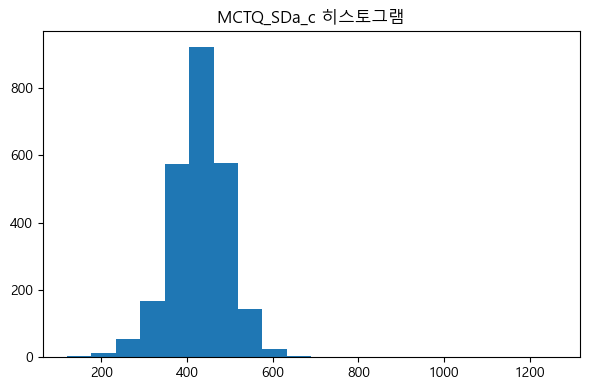

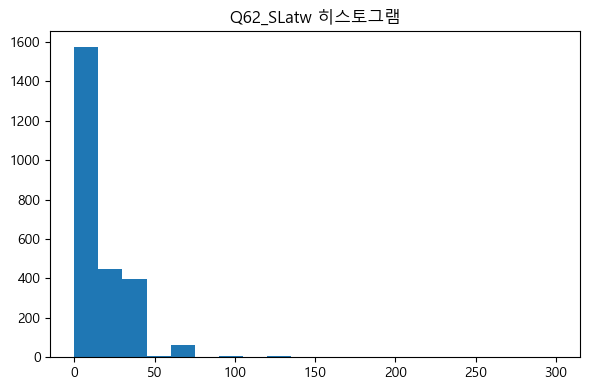

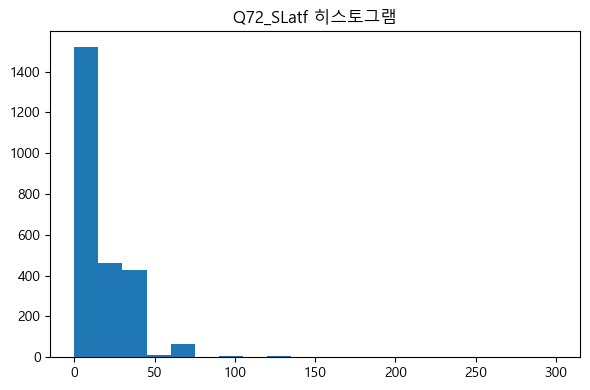

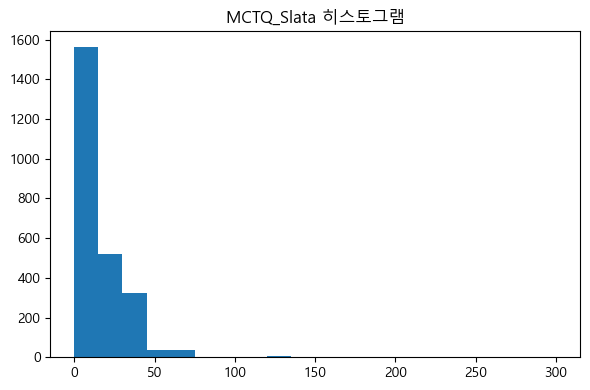

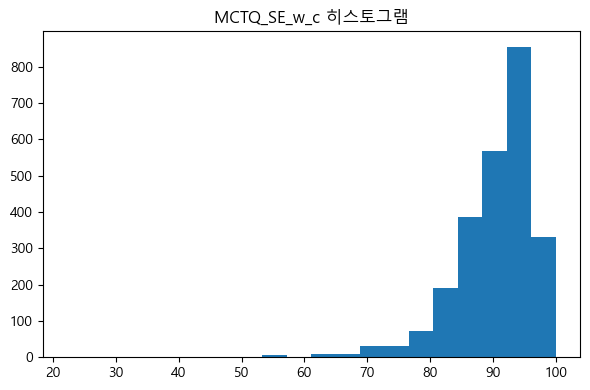

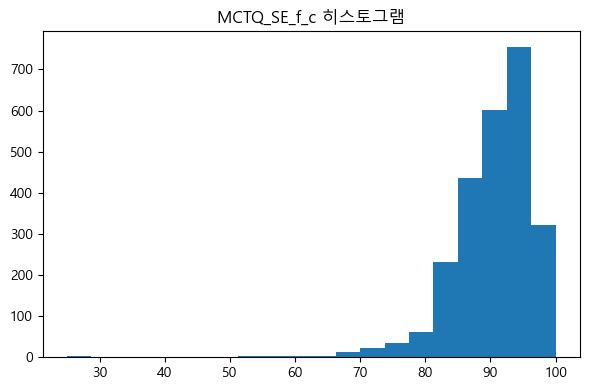

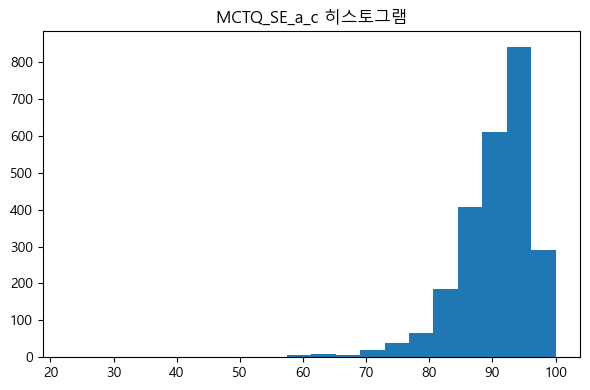

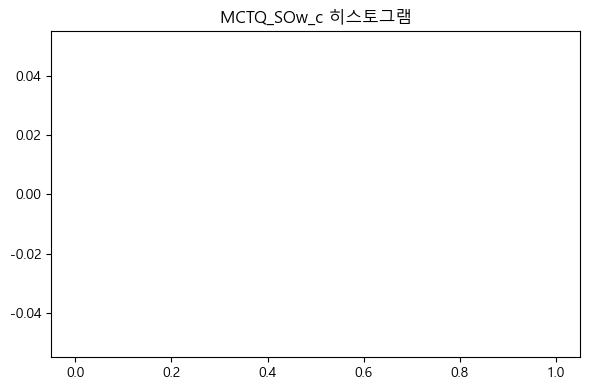

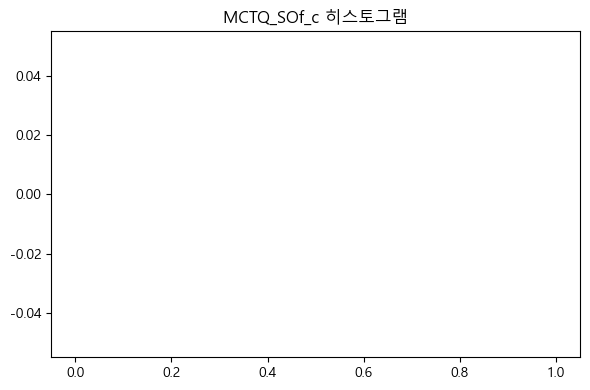

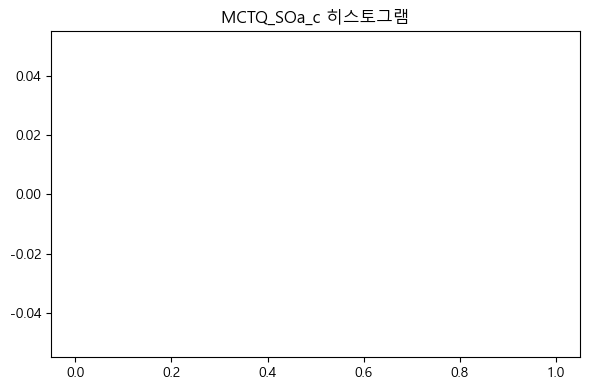

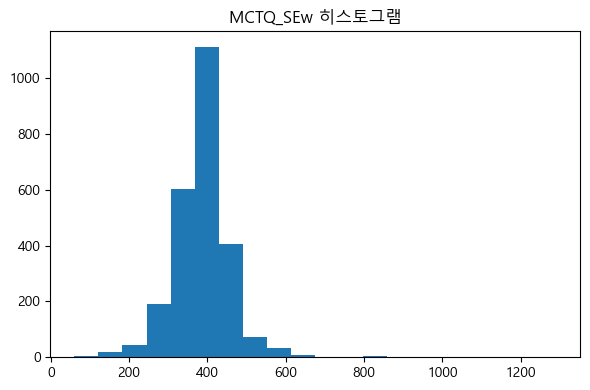

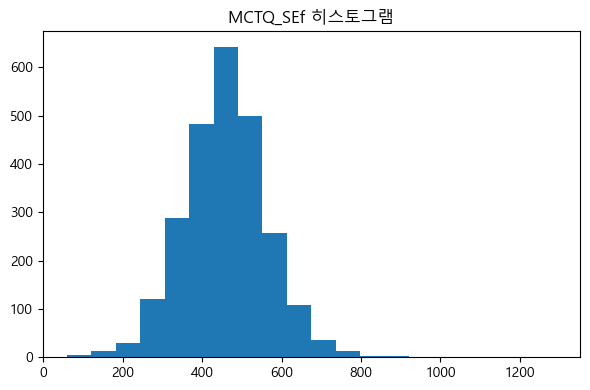

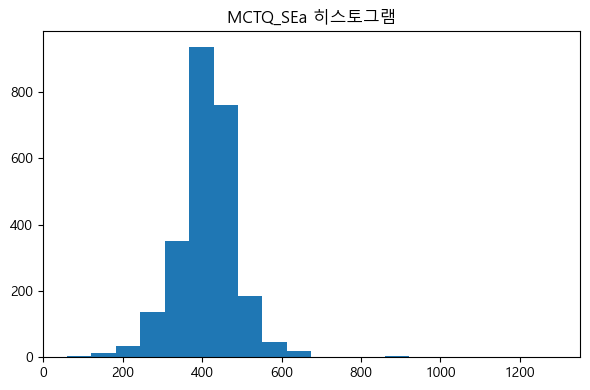

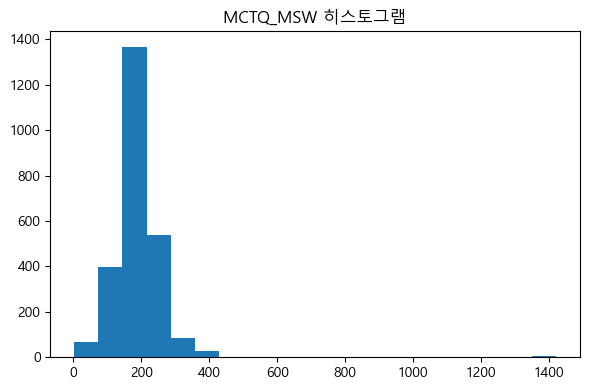

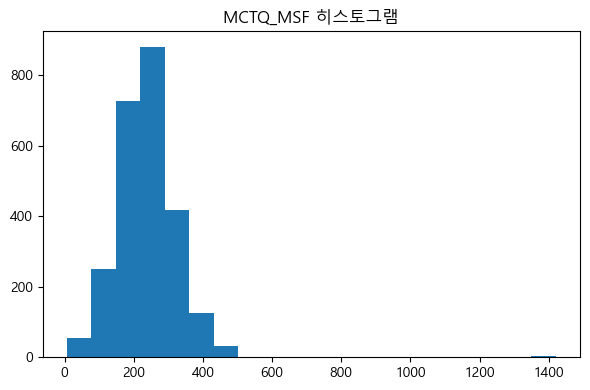

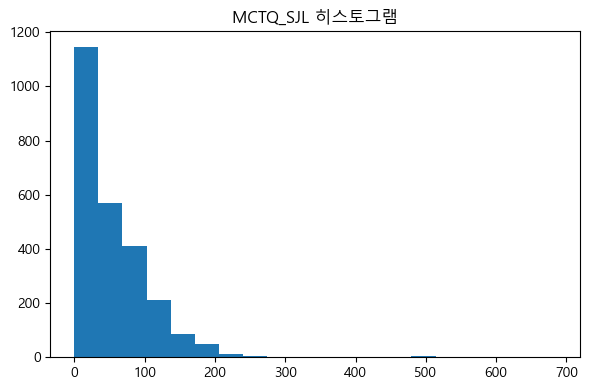

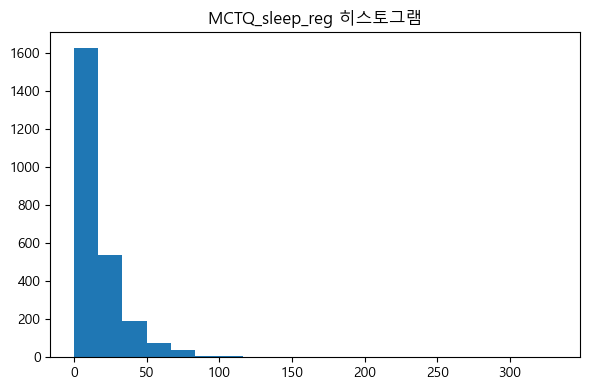

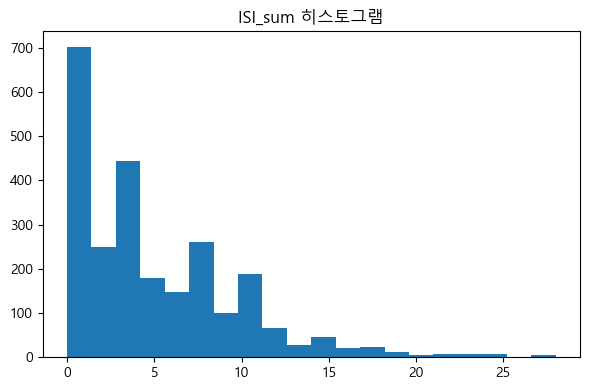

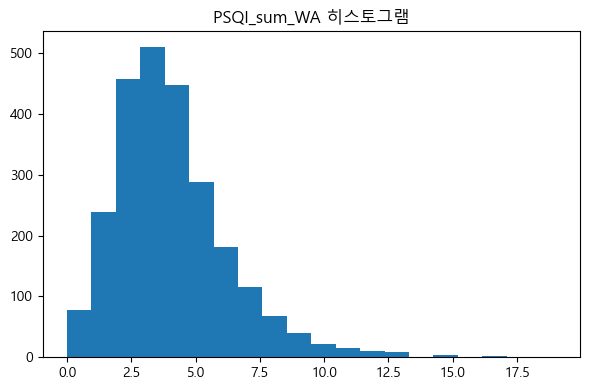

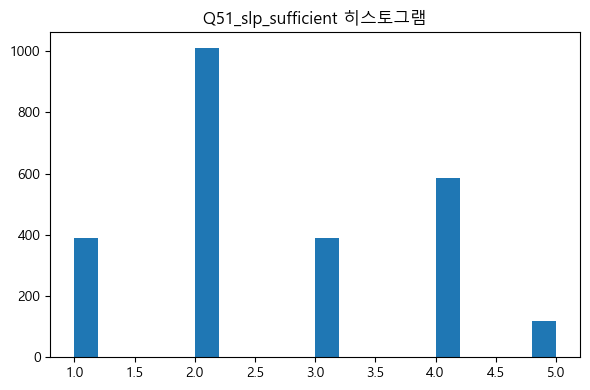

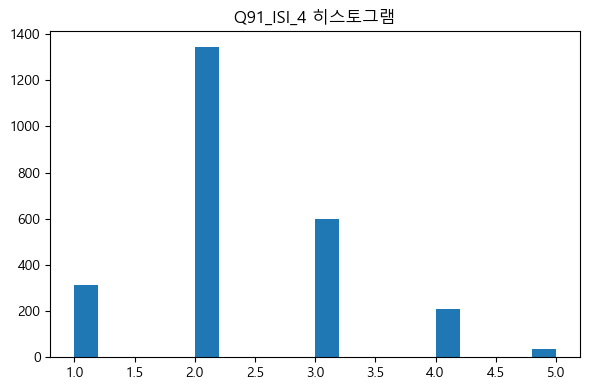

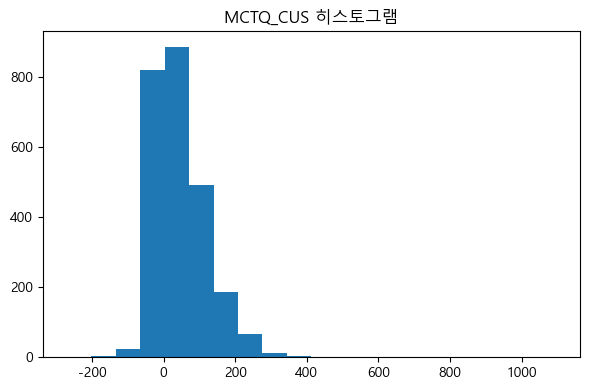

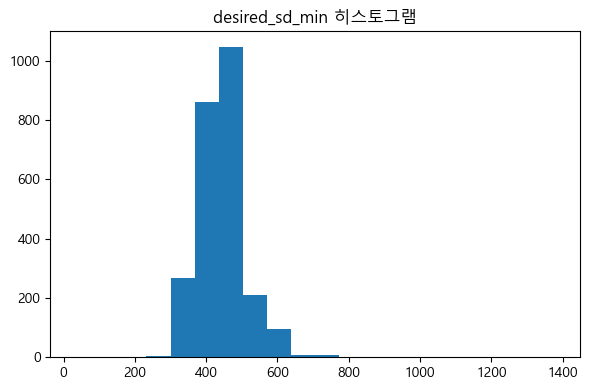

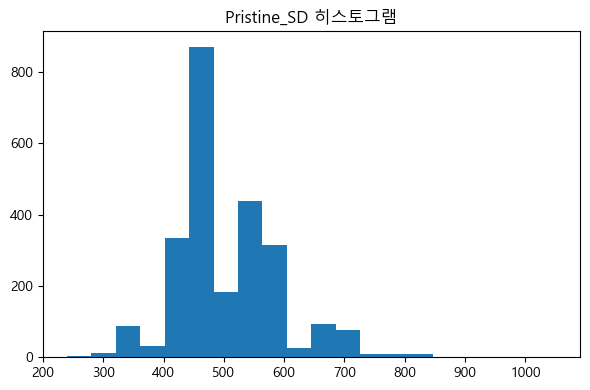

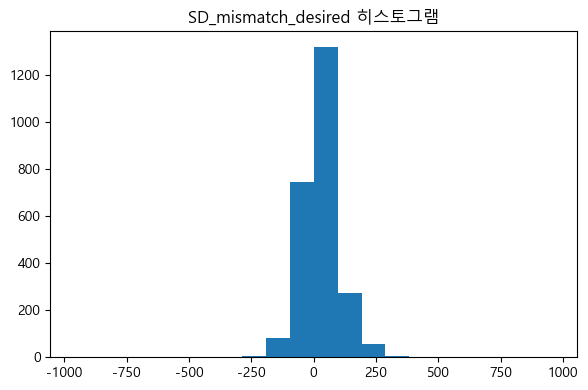

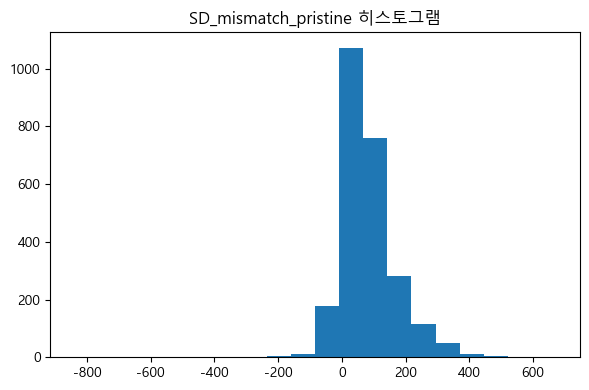

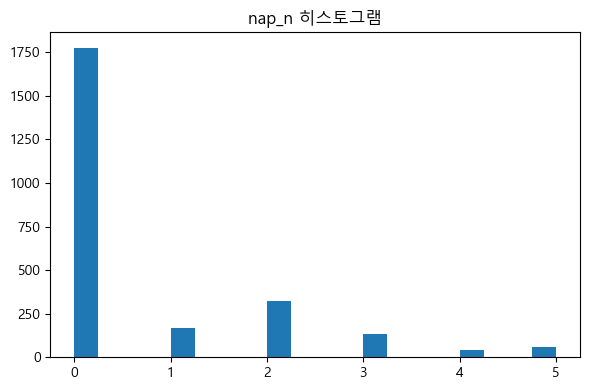

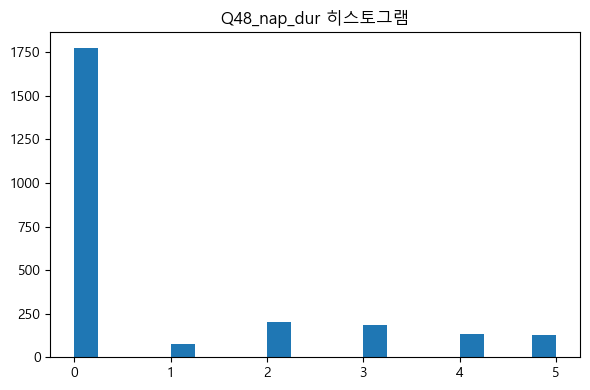

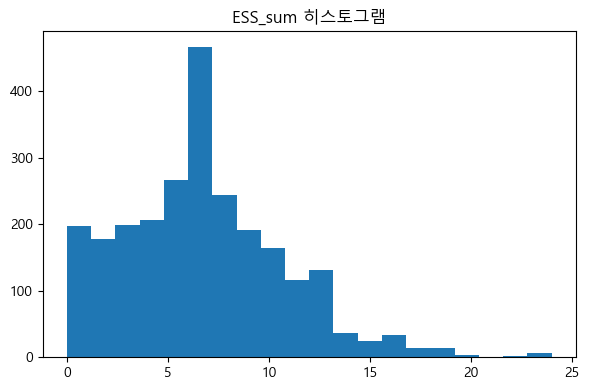

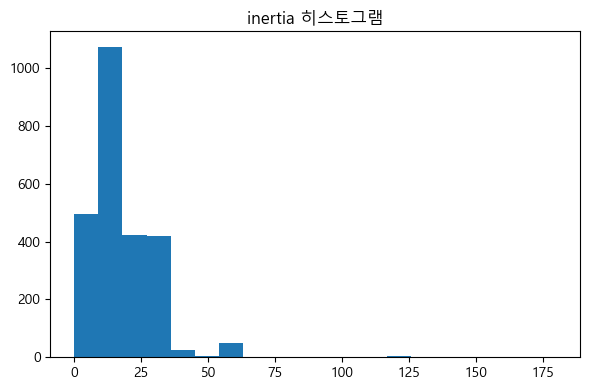

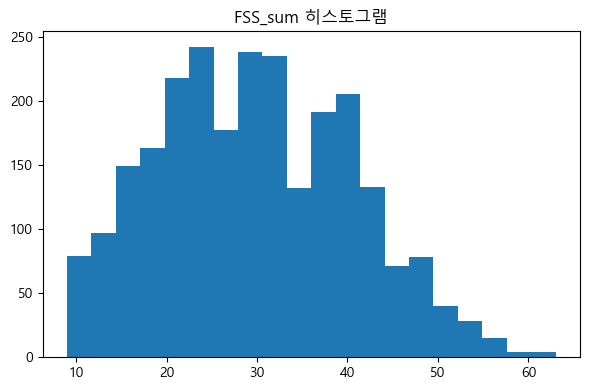

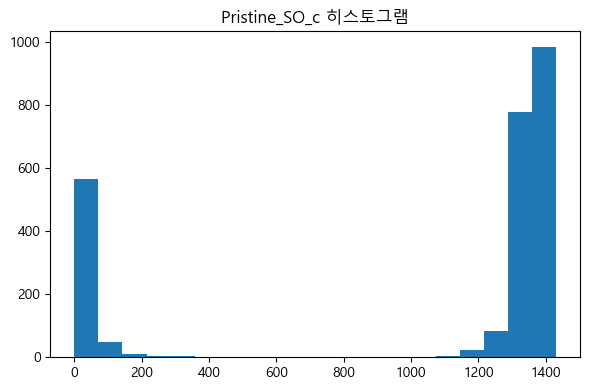

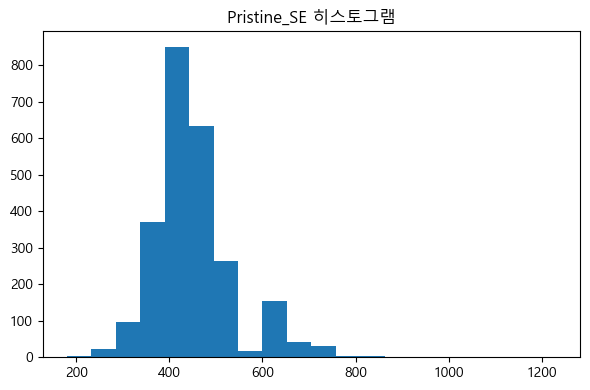

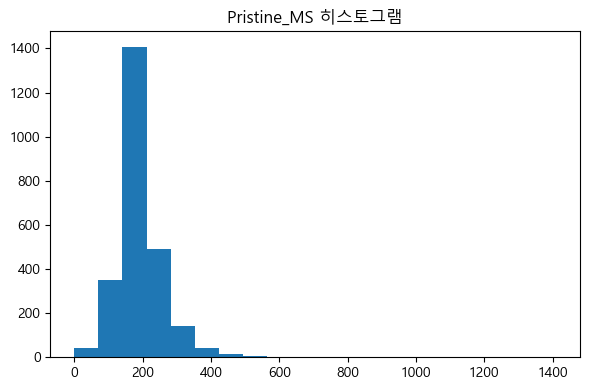

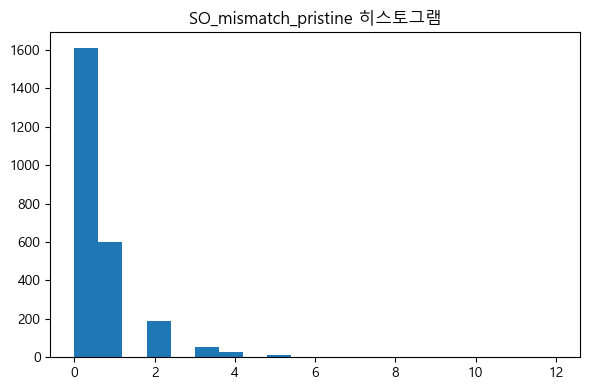

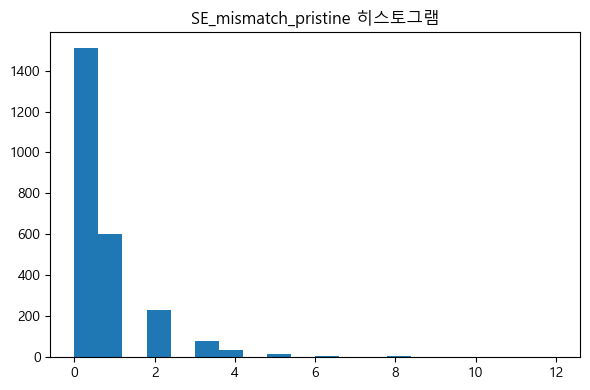

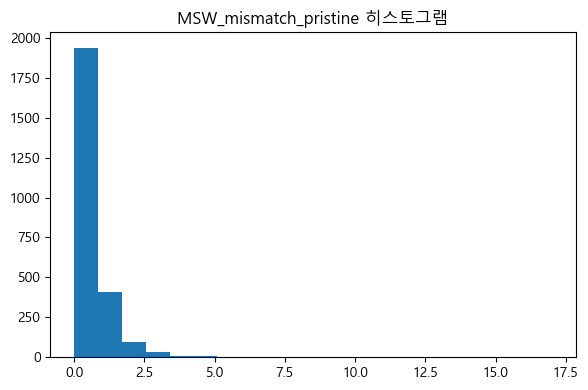

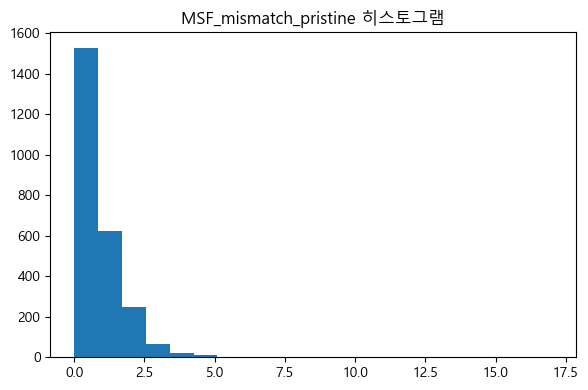

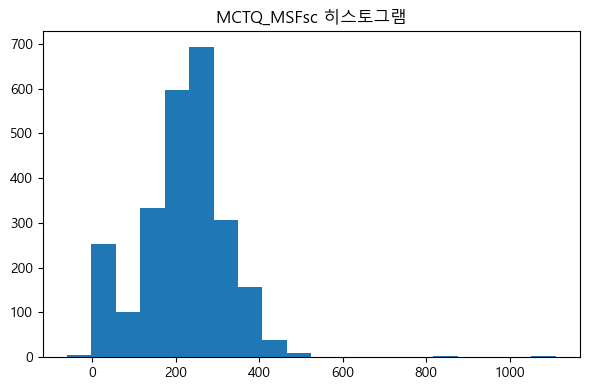

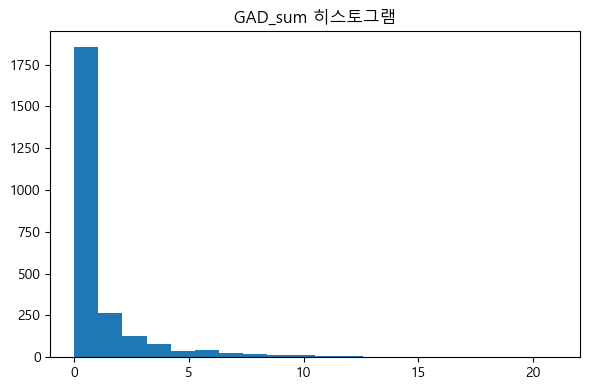

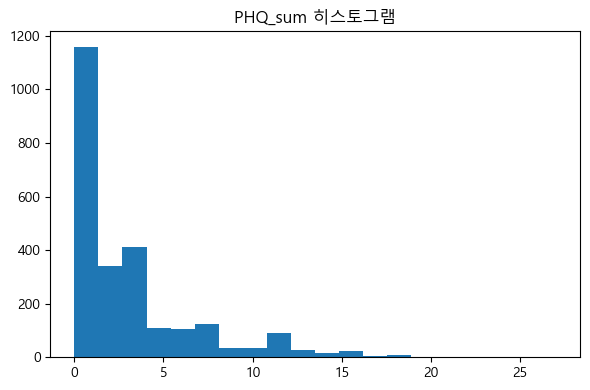

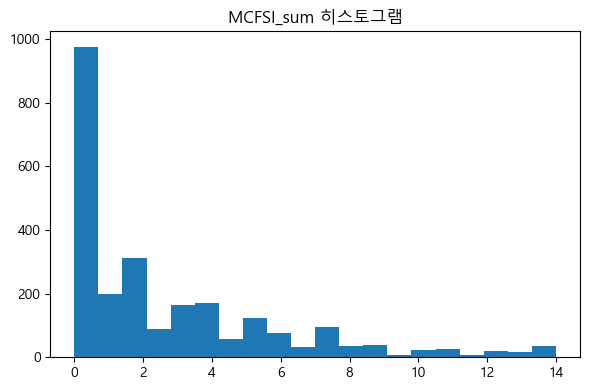

In [12]:

# ==== 연속형 시각화: 히스토그램 ====
if continuous_vars:
    n = len(continuous_vars)
    # 개별 플롯으로 저장
    for col in continuous_vars:
        try:
            plt.figure(figsize=(6,4))
            plt.hist(df[col].dropna(), bins=20)
            plt.title(f"{col} 히스토그램")
            plt.tight_layout()
            plt.savefig(f"{OUT_DIR}/{col}_hist.png", dpi=150)
            plt.show()
        except Exception as e:
            print(f"[경고] {col} 히스토그램 실패:", e)


[t-test] ISI_sum ~ age_group(2 vs 5) -> t=-3.482, p=5.301e-04


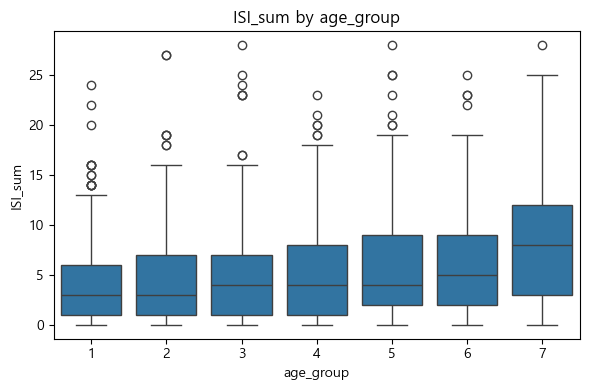

[t-test] PSQI_sum_WA ~ sex(1 vs 2) -> t=-2.756, p=5.903e-03


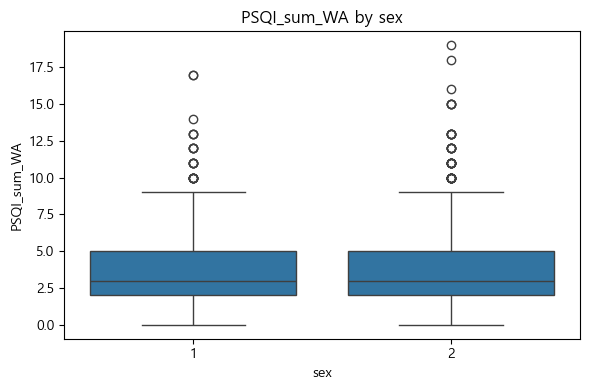

In [7]:

# ==== 기본 집단 비교 ====
def ttest_two_groups(frame, group_col, target_col, g1_val, g0_val):
    if group_col not in frame.columns or target_col not in frame.columns:
        print(f"[skip] {group_col} 또는 {target_col} 없음")
        return
    g1 = frame[frame[group_col] == g1_val][target_col].dropna()
    g0 = frame[frame[group_col] == g0_val][target_col].dropna()
    if len(g1) < 2 or len(g0) < 2:
        print(f"[skip] 표본 부족: {group_col}={g1_val}/{g0_val} - {target_col}")
        return
    t, p = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"[t-test] {target_col} ~ {group_col}({g1_val} vs {g0_val}) -> t={t:.3f}, p={p:.3e}")
    # boxplot
    try:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=frame[[group_col, target_col]].dropna(), x=group_col, y=target_col)
        plt.title(f"{target_col} by {group_col}")
        plt.tight_layout()
        fname = f"{OUT_DIR}/{target_col}_by_{group_col}.png".replace("/", "_")
        plt.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        print(f"[경고] 박스플롯 실패: {e}")

# 예시: 나이(30대 vs 60대) 별 불면증 심각도(ISI)
for candidate in ["ISI_sum"]:
    if "age_group" in df.columns and candidate in df.columns:
        ttest_two_groups(df, "age_group", candidate, 2, 5)



# for candidate in ["평균 수면시간", "평균 수면효율", "피처버그 수면의 질 지수 (PSQI)", "불면증 심각도 척도 (ISI)"]:
#     if "SW" in df.columns and candidate in df.columns:
#         ttest_two_groups(df, "SW", candidate, 2, 5)

# 예시: 성별(sex) vs PSQI
if "sex" in df.columns and "PSQI_sum_WA" in df.columns:
    # 성별 코딩은 데이터에 맞게 조정(0/1, 1/2 등)
    # 아래는 1 vs 0 비교 예시
    ttest_two_groups(df, "sex", "PSQI_sum_WA", 1, 2)


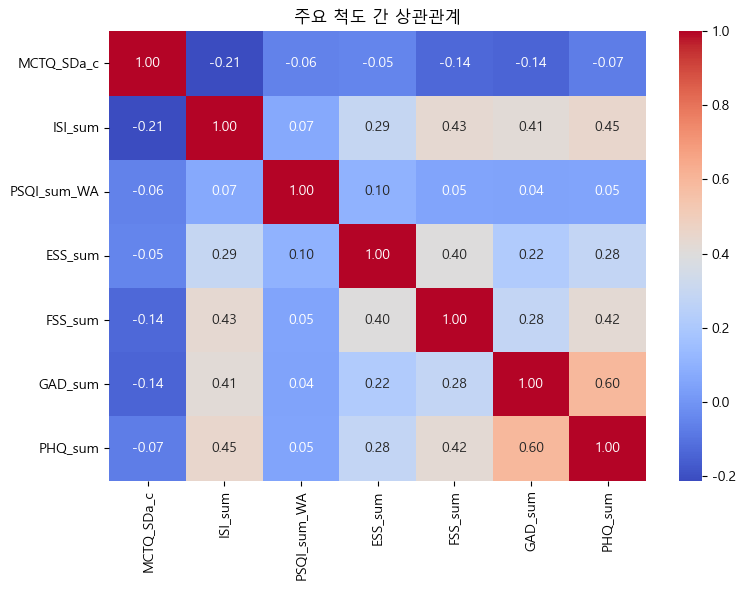

In [9]:

# ==== 상관 히트맵 (주요 척도) ====
scale_candidates = [
    "MCTQ_SDa_c", # 평균 수면시간
    "ISI_sum", # 불면증 심각도 척도
    "PSQI_sum_WA", # 피처버그 수면의 질 지수
    "ESS_sum", # 앱워스 졸음척도
    "FSS_sum", # 피로 증상 척도
    "GAD_sum", # 범불안장애 7문항 척도
    "PHQ_sum", # 우울증 건강설문 9문항 (PHQ-9)
]

scale_cols = [c for c in scale_candidates if c in df.columns]
if len(scale_cols) >= 2:
    corr = df[scale_cols].corr(method="pearson")
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("주요 척도 간 상관관계")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/scales_corr_heatmap.png", dpi=150)
    plt.show()
else:
    print("[skip] 상관분석에 충분한 척도 컬럼이 없습니다:", scale_cols)


[EFA] 고유값(Eigenvalues): [2.54675024 1.01213513 0.89023063 0.63468619 0.53987061 0.37632719]


,Factor1,Factor2
ISI_sum,0.414752,0.468006
PSQI_sum_WA,0.030715,0.102436
ESS_sum,0.161678,0.493872
FSS_sum,0.214314,0.733011
GAD_sum,0.832635,0.151889
PHQ_sum,0.650123,0.375891


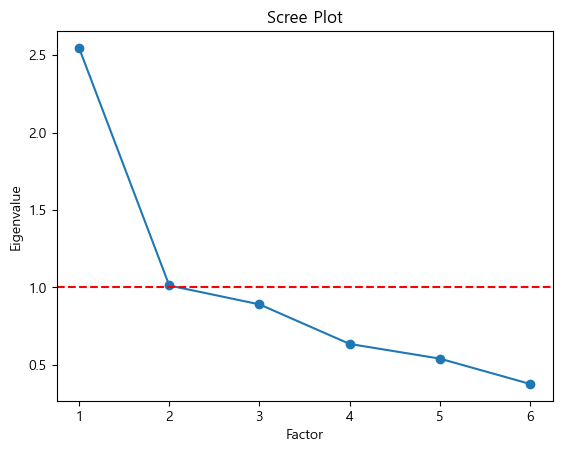

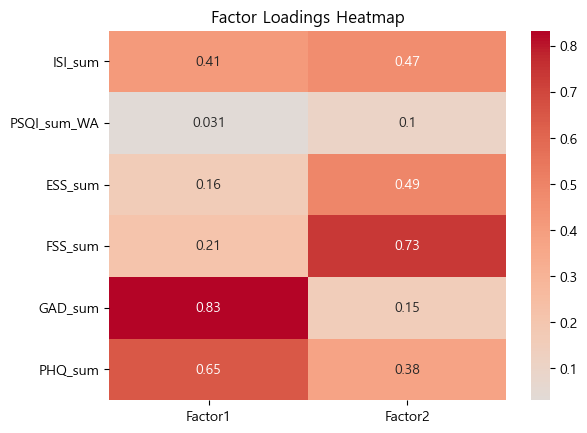

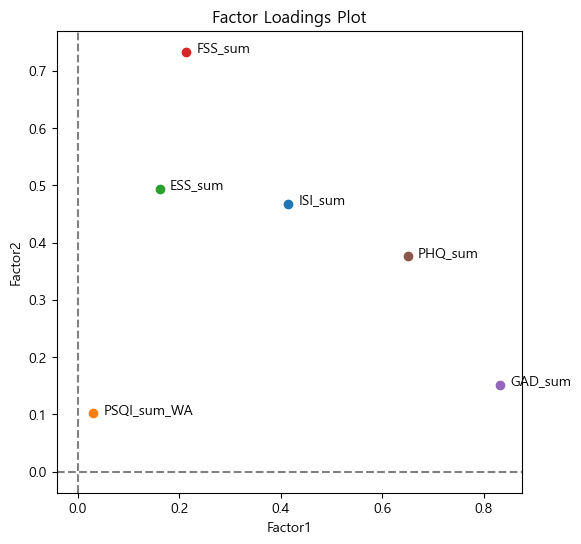

In [ ]:

# ==== 탐색적 요인분석 (선택) ====
if HAS_FACTOR:
    fa_vars = [c for c in [
    "ISI_sum", # 불면증 심각도 척도
    "PSQI_sum_WA", # 피처버그 수면의 질 지수
    "ESS_sum", # 앱워스 졸음척도
    "FSS_sum", # 피로 증상 척도
    "GAD_sum", # 범불안장애 7문항 척도
    "PHQ_sum", # 우울증 건강설문 9문항 (PHQ-9)
    ] if c in df.columns]

    if len(fa_vars) >= 3:
        fa_data = df[fa_vars].dropna()
        try:
            fa = FactorAnalyzer(n_factors=2, rotation="varimax")
            fa.fit(fa_data)
            eigenvals, _ = fa.get_eigenvalues()
            print("[EFA] 고유값(Eigenvalues):", eigenvals[:len(fa_vars)])

            loadings = pd.DataFrame(fa.loadings_, index=fa_vars, columns=["Factor1", "Factor2"])
            display(loadings)

        except Exception as e:
            print("[경고] 요인분석 실패:", e)
    else:
        print("[skip] 요인분석 변수 수 부족:", fa_vars)
else:
    print("[skip] factor_analyzer 미설치")

# 시각화
# Scree plot
plt.plot(range(1, len(eigenvals)+1), eigenvals, marker='o')
plt.axhline(1, color='red', linestyle='--')  # 기준선
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

# Heatmap
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Factor Loadings Heatmap")
plt.show()

# Loading scatter plot (Factor1 vs Factor2)
plt.figure(figsize=(6,6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
for var in loadings.index:
    x, y = loadings.loc[var, "Factor1"], loadings.loc[var, "Factor2"]
    plt.scatter(x, y)
    plt.text(x+0.02, y, var)
plt.xlabel("Factor1")
plt.ylabel("Factor2")
plt.title("Factor Loadings Plot")
plt.show()

In [ ]:
# EFA 결과를 바탕으로 CFA 모델링 (단, 별도의 데이터셋이 필요하므로 코드를 돌리긴 했지만 유의한 지표는 아님)

from semopy import Model
import pandas as pd

# CFA 모델 정의 (lavaan-style syntax) -> EFA 결과에 맞게 임의로 판단
desc = """
Factor1 =~ GAD_sum + PHQ_sum
Factor2 =~ ISI_sum + ESS_sum + FSS_sum
"""

model = Model(desc)
model.fit(df)  # df는 원 데이터셋 (관찰변수들 포함된 DataFrame)

# 요인 부하량, 적합도 지표 확인
est = model.inspect()
print(est)

from semopy import calc_stats
stats = calc_stats(model)
print(stats)


       lval  op     rval   Estimate  Std. Err    z-value p-value
0   GAD_sum   ~  Factor1   1.000000         -          -       -
1   PHQ_sum   ~  Factor1   2.111087   0.08559  24.665007     0.0
2   ISI_sum   ~  Factor2   1.000000         -          -       -
3   ESS_sum   ~  Factor2   0.639267  0.033656  18.994135     0.0
4   FSS_sum   ~  Factor2   2.422078  0.103737  23.348184     0.0
5   Factor1  ~~  Factor1   2.387537   0.14733  16.205376     0.0
6   Factor2  ~~  Factor2   9.374519   0.60971  15.375367     0.0
7   Factor2  ~~  Factor1   3.431438  0.200105  17.148172     0.0
8   ESS_sum  ~~  ESS_sum  12.049800  0.386385  31.185993     0.0
9   FSS_sum  ~~  FSS_sum  58.355750   2.59458  22.491409     0.0
10  GAD_sum  ~~  GAD_sum   2.683471  0.112513  23.850234     0.0
11  ISI_sum  ~~  ISI_sum  12.015167  0.486589  24.692662     0.0
12  PHQ_sum  ~~  PHQ_sum   3.484726  0.383111   9.095866     0.0
       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline      CFI  \
Value    4  

In [13]:

# ==== 카이제곱 (두 범주형 변수의 독립성 유무) ====
from scipy.stats import chi2_contingency

def chi_square_two(frame, col_a, col_b):
    if col_a not in frame.columns or col_b not in frame.columns:
        print(f"[skip] {col_a} 또는 {col_b} 없음")
        return
    ct = pd.crosstab(frame[col_a], frame[col_b])
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        print(f"[skip] 교차표 차원 부족: {col_a} x {col_b}")
        return
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"[chi2] {col_a} x {col_b} -> chi2={chi2:.3f}, p={p:.3e}, dof={dof}")
    display(ct)

# 고혈압 vs 임계 이상 척도(불면증, 수면질, 졸음척도, 피로, 불안, 우울증)
for bcol in ["insomnia", "poor_sleeper", "EDS", "fatigue", "anxiety", "depression"]:
    if "D1_1_HT" in df.columns and bcol in df.columns:
        chi_square_two(df, "D1_1_HT", bcol)

# 당뇨 vs 임계 이상 척도(불면증, 수면질, 졸음척도, 피로, 불안, 우울증)
for bcol in ["insomnia", "poor_sleeper", "EDS", "fatigue", "anxiety", "depression"]:
    if "D1_2_DM" in df.columns and bcol in df.columns:
        chi_square_two(df, "D1_2_DM", bcol)


# 고지혈증 vs 임계 이상 척도(불면증, 수면질, 졸음척도, 피로, 불안, 우울증)
for bcol in ["insomnia", "poor_sleeper", "EDS", "fatigue", "anxiety", "depression"]:
    if "D1_3_HLP" in df.columns and bcol in df.columns:
        chi_square_two(df, "D1_3_HLP", bcol)


[chi2] D1_1_HT x insomnia -> chi2=76.772, p=1.919e-18, dof=1


insomnia,0.0,1.0
D1_1_HT,,
1,301,135
2,1782,281


[chi2] D1_1_HT x poor_sleeper -> chi2=6.152, p=1.313e-02, dof=1


poor_sleeper,0.0,1.0
D1_1_HT,,
1,331,105
2,1669,385


[chi2] D1_1_HT x EDS -> chi2=53.182, p=3.041e-13, dof=1


EDS,0.0,1.0
D1_1_HT,,
1,319,117
2,1796,265


[chi2] D1_1_HT x fatigue -> chi2=17.216, p=3.336e-05, dof=1


fatigue,0.0,1.0
D1_1_HT,,
1,265,171
2,1465,598


[chi2] D1_1_HT x anxiety -> chi2=1.752, p=1.856e-01, dof=1


anxiety,0,1
D1_1_HT,,
1,427,10
2,2037,27


[chi2] D1_1_HT x depression -> chi2=36.554, p=1.485e-09, dof=1


depression,0.0,1.0
D1_1_HT,,
1,367,69
2,1920,141


[chi2] D1_2_DM x insomnia -> chi2=51.536, p=7.031e-13, dof=1


insomnia,0.0,1.0
D1_2_DM,,
1,145,75
2,1938,341


[chi2] D1_2_DM x poor_sleeper -> chi2=5.502, p=1.899e-02, dof=1


poor_sleeper,0.0,1.0
D1_2_DM,,
1,163,57
2,1837,433


[chi2] D1_2_DM x EDS -> chi2=36.595, p=1.454e-09, dof=1


EDS,0.0,1.0
D1_2_DM,,
1,155,65
2,1960,317


[chi2] D1_2_DM x fatigue -> chi2=3.258, p=7.106e-02, dof=1


fatigue,0.0,1.0
D1_2_DM,,
1,140,80
2,1590,689


[chi2] D1_2_DM x anxiety -> chi2=0.516, p=4.727e-01, dof=1


anxiety,0,1
D1_2_DM,,
1,216,5
2,2248,32


[chi2] D1_2_DM x depression -> chi2=14.334, p=1.531e-04, dof=1


depression,0.0,1.0
D1_2_DM,,
1,187,34
2,2100,176


[chi2] D1_3_HLP x insomnia -> chi2=43.614, p=3.999e-11, dof=1


insomnia,0.0,1.0
D1_3_HLP,,
1,105,58
2,1978,358


[chi2] D1_3_HLP x poor_sleeper -> chi2=3.866, p=4.927e-02, dof=1


poor_sleeper,0.0,1.0
D1_3_HLP,,
1,120,42
2,1880,448


[chi2] D1_3_HLP x EDS -> chi2=44.270, p=2.861e-11, dof=1


EDS,0.0,1.0
D1_3_HLP,,
1,108,55
2,2007,327


[chi2] D1_3_HLP x fatigue -> chi2=23.030, p=1.595e-06, dof=1


fatigue,0.0,1.0
D1_3_HLP,,
1,85,78
2,1645,691


[chi2] D1_3_HLP x anxiety -> chi2=1.925, p=1.653e-01, dof=1


anxiety,0,1
D1_3_HLP,,
1,159,5
2,2305,32


[chi2] D1_3_HLP x depression -> chi2=15.919, p=6.610e-05, dof=1


depression,0.0,1.0
D1_3_HLP,,
1,136,28
2,2151,182


In [ ]:
### 이건 여기서 쓴 건 아니고, 참고용으로 남겨둠 ###

import pandas as pd
import matplotlib.pyplot as plt

# 수집된 chi2 결과를 표 형태로 정리
data = [
    # D1_1_HT (고혈압)
    ["Hypertension", "Insomnia", 76.772, 1.919e-18],
    ["Hypertension", "Poor sleeper", 6.152, 1.313e-02],
    ["Hypertension", "EDS", 53.182, 3.041e-13],
    ["Hypertension", "Fatigue", 17.216, 3.336e-05],
    ["Hypertension", "Anxiety", 1.752, 1.856e-01],
    ["Hypertension", "Depression", 36.554, 1.485e-09],
    # D1_2_DM (당뇨)
    ["Diabetes", "Insomnia", 51.536, 7.031e-13],
    ["Diabetes", "Poor sleeper", 5.502, 1.899e-02],
    ["Diabetes", "EDS", 36.595, 1.454e-09],
    ["Diabetes", "Fatigue", 3.258, 7.106e-02],
    ["Diabetes", "Anxiety", 0.516, 4.727e-01],
    ["Diabetes", "Depression", 14.334, 1.531e-04],
    # D1_3_HLP (고지혈증)
    ["Hyperlipidemia", "Insomnia", 43.614, 3.999e-11],
    ["Hyperlipidemia", "Poor sleeper", 3.866, 4.927e-02],
    ["Hyperlipidemia", "EDS", 44.270, 2.861e-11],
    ["Hyperlipidemia", "Fatigue", 23.030, 1.595e-06],
    ["Hyperlipidemia", "Anxiety", 1.925, 1.653e-01],
    ["Hyperlipidemia", "Depression", 15.919, 6.610e-05],
]

df = pd.DataFrame(data, columns=["Disease", "Symptom", "Chi2", "p-value"])

# -log10 p-value로 시각화하면 더 직관적
df["-log10(p)"] = -df["p-value"].apply(lambda x: pd.np.log10(x))

# 그래프: 질환별 subplot, 증상별 barplot
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, disease in zip(axes, df["Disease"].unique()):
    subset = df[df["Disease"] == disease]
    ax.barh(subset["Symptom"], subset["-log10(p)"], color="steelblue")
    ax.axvline(-pd.np.log10(0.05), color="red", linestyle="--", label="p=0.05")
    ax.set_title(disease)
    ax.invert_yaxis()
    ax.set_xlabel("-log10(p)")
    ax.legend()

plt.suptitle("Chi-square Test Results (-log10 p-values)\nHigher = More Significant Association", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
